In [213]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

In [214]:
articles = pd.read_csv("../zalando_files/articles.csv", encoding='utf-16')

In [215]:
orders = pd.read_csv("../zalando_files/orders.csv", encoding='utf-16')

In [216]:
customers = pd.read_csv("../zalando_files/customers.csv", encoding='utf-16')

/var/folders/cs/28k39qrd4fd91ybwdd69fndw0000gn/T/ipykernel_3072/2876716713.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv("../zalando_files/customers.csv", encoding='utf-16')


In [217]:
returns = pd.read_csv("../zalando_files/returns.csv", encoding='utf-16')

In [218]:
articles.head()

,simple_sku,config_sku,article_size,product_category,brand_name
0,BNE211S048-A110012000,BNE211S048-A11,40,Sneakers,Puma
1,XAN621CAJM-Q110036000,XAN621CAJM-Q11,36,Dresses,MANGO
2,APU111S06U-Q110007000,APU111S06U-Q11,40.5,Sneakers,NEW Balance
3,APU111S06U-Q110065000,APU111S06U-Q11,40,Sneakers,NEW Balance
4,APU115B04J-C110045000,APU115B04J-C11,37.5,Sneakers,NEW Balance


In [219]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6010136 entries, 0 to 6010135
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_number            int64  
 1   order_item_position     int64  
 2   config_sku              object 
 3   size_sku                object 
 4   customer_id             int64  
 5   order_date              object 
 6   gmv_before_return       float64
 7   discount_before_return  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 366.8+ MB


In [220]:
customers.head()

,customer_id,customer_gender,country,customer_quality
0,36751175,Women,France,2
1,211454424,Women,Germany,1
2,317213832,Women,France,3
3,418394519,Women,Sweden,2
4,269428195,Women,Sweden,4


In [221]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3462923 entries, 0 to 3462922
Data columns (total 5 columns):
 #   Column               Dtype  
---  ------               -----  
 0   order_number         int64  
 1   order_item_position  int64  
 2   simple_sku           object 
 3   return_date_sku      float64
 4   return_reason        object 
dtypes: float64(1), int64(2), object(2)
memory usage: 132.1+ MB


In [222]:
articles.isna().sum()

simple_sku          0
config_sku          0
article_size        0
product_category    0
brand_name          0
dtype: int64

In [223]:
customers.isna().sum()

customer_id         0
customer_gender     0
country             0
customer_quality    0
dtype: int64

In [224]:
orders.isna().sum()

order_number              0
order_item_position       0
config_sku                0
size_sku                  0
customer_id               0
order_date                0
gmv_before_return         0
discount_before_return    0
dtype: int64

In [225]:
returns.isna().sum()

order_number           0
order_item_position    0
simple_sku             0
return_date_sku        0
return_reason          0
dtype: int64

In [226]:
conn = sqlite3.connect('zalando.db')

In [227]:
articles.to_sql('articles', conn, index=False, if_exists='replace')
orders.to_sql('orders', conn, index=False, if_exists='replace')
customers.to_sql('customers', conn, index=False, if_exists='replace')
returns.to_sql('returns', conn, index=False, if_exists='replace')

OperationalError: database or disk is full

In [ ]:
query = """
SELECT 
o.*,
r.*,
c.*,
a.*
FROM orders o
JOIN customers c 
    ON c.customer_id = o.customer_id
LEFT JOIN returns r 
    ON o.order_number = r.order_number
    AND o."order_item_position" = r."order_item_position"
LEFT JOIN articles a 
    ON r.simple_sku = a.simple_sku
"""

df = pd.read_sql_query(query, conn)
print(df.head())

   order_number  order_item_position      config_sku size_sku  customer_id  \
0     330812595            930364825  BNE211S048-A11  0012000     36751175   
1     330817221            930336225  XAN621CAJM-Q11  0036000    211454424   
2     330818553            930351730  APU111S06U-Q11  0007000    317213832   
3     330818553            930351731  APU111S06U-Q11  0065000    317213832   
4     330818585            930353320  APU115B04J-C11  0045000    418394519   

   order_date  gmv_before_return  discount_before_return  order_number  \
0  2022-01-01              79.95                   20.00           NaN   
1  2022-01-01              28.00                   11.95           NaN   
2  2022-01-01              59.95                   40.00   330818553.0   
3  2022-01-01              59.95                   40.00   330818553.0   
4  2022-01-01              65.99                   44.00           NaN   

   order_item_position             simple_sku  return_date_sku return_reason  \
0     

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df['return_reason'] = df['return_reason'].replace({'Unkown': 'Unknown'})

In [ ]:
df['brand_name'] = df['brand_name'].replace({'Jack and Jones': 'Jack & Jones'})

In [ ]:
df['is_returned'] = df['return_reason'].notnull().astype(int)

In [ ]:
df['article_size'] = pd.to_numeric(df['article_size'], errors='coerce')

In [ ]:
def sneaker_size(row):
    if row['product_category'] != 'Sneakers':
        return None

    size = row['article_size']

    if pd.isna(size):
        return None
    elif size <= 38:
        return 'Small'
    elif 39 <= size <= 41:
        return 'Medium'
    elif size >= 42:
        return 'Large'
    else:
        return None
    

In [ ]:
def dress_size(row):
    
    if row['product_category'] != 'Dresses':
        return None

    size = row['article_size']

    if pd.isna(size):
        return None
    if size <= 34:
        return 'XS'
    elif 35 <= size <= 36:
        return 'S'
    elif 37 <= size <= 38:
        return 'M'
    elif 39 <= size <= 42:
        return 'L'
    elif size > 42:
        return 'XL'
    else:
        return None
    

In [ ]:
def jean_size(row):

    if row['product_category'] != 'Jeans'
        return None

    size = row['article_size']

    if pd.isna(size)
        return None
    
    if size <= 27:
        return 'XS'
    elif 28 <= size <= 30:
        return 'S'
    elif 31 <= size <= 33:
        return 'M'
    elif 34 <= size <= 36:
        return 'L'
    elif size > 36:
        return 'XL'
    else:
        return None
    

In [ ]:
df['sneaker_sizes'] = df.apply(sneaker_size, axis=1)

In [ ]:
df['dress_sizes'] = df.apply(dress_size, axis=1)

In [ ]:
df['size_type'] = 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6010136 entries, 0 to 6010135
Data columns (total 23 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_number            int64  
 1   order_item_position     int64  
 2   config_sku              object 
 3   size_sku                object 
 4   customer_id             int64  
 5   order_date              object 
 6   gmv_before_return       float64
 7   discount_before_return  float64
 8   order_number            float64
 9   order_item_position     float64
 10  simple_sku              object 
 11  return_date_sku         float64
 12  return_reason           object 
 13  customer_id             int64  
 14  customer_gender         object 
 15  country                 object 
 16  customer_quality        object 
 17  simple_sku              object 
 18  config_sku              object 
 19  article_size            object 
 20  product_category        object 
 21  brand_name              object 

In [ ]:
df['is_returned'].value_counts()

is_returned
1    3462923
0    2547213
Name: count, dtype: int64

In [ ]:
df['order_date'] = pd.to_datetime(df['order_date'])

In [ ]:
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['day'] = df['order_date'].dt.day
df['day_of_week'] = df['order_date'].dt.day_of_week

In [ ]:
df.head(10)

,order_number,order_item_position,config_sku,size_sku,customer_id,order_date,gmv_before_return,discount_before_return,order_number,order_item_position,simple_sku,return_date_sku,return_reason,customer_id,customer_gender,country,customer_quality,simple_sku,config_sku,article_size,product_category,brand_name,is_returned,year,month,day,day_of_week,size_type,dress_sizes,sneaker_sizes
0,330812595,930364825,BNE211S048-A11,0012000,36751175,2022-01-01,79.95,20.00,NaN,NaN,None,NaN,None,36751175,Women,France,2,None,None,NaN,None,None,0,2022,1,1,5,None,None,None
1,330817221,930336225,XAN621CAJM-Q11,0036000,211454424,2022-01-01,28.00,11.95,NaN,NaN,None,NaN,None,211454424,Women,Germany,1,None,None,NaN,None,None,0,2022,1,1,5,None,None,None
2,330818553,930351730,APU111S06U-Q11,0007000,317213832,2022-01-01,59.95,40.00,330818553.0,930351730.0,APU111S06U-Q110007000,20220115.0,Unknown,317213832,Women,France,3,APU111S06U-Q110007000,APU111S06U-Q11,40.5,Sneakers,NEW Balance,1,2022,1,1,5,Medium,None,Medium
3,330818553,930351731,APU111S06U-Q11,0065000,317213832,2022-01-01,59.95,40.00,330818553.0,930351731.0,APU111S06U-Q110065000,20220115.0,Unknown,317213832,Women,France,3,APU111S06U-Q110065000,APU111S06U-Q11,40.0,Sneakers,NEW Balance,1,2022,1,1,5,Medium,None,Medium
4,330818585,930353320,APU115B04J-C11,0045000,418394519,2022-01-01,65.99,44.00,NaN,NaN,None,NaN,None,418394519,Women,Sweden,2,None,None,NaN,None,None,0,2022,1,1,5,None,None,None
5,330818587,930364855,XAN621CALS-G11,0042000,269428195,2022-01-01,39.99,0.00,NaN,NaN,None,NaN,None,269428195,Women,Sweden,4,None,None,NaN,None,None,0,2022,1,1,5,None,None,None
6,330820148,930385967,APU111S07A-Q11,0075000,35628035,2022-01-01,51.95,13.00,NaN,NaN,None,NaN,None,35628035,Women,France,4,None,None,NaN,None,None,0,2022,1,1,5,None,None,None
7,330820206,930386843,XAN621CAIB-Q11,0044000,43591638,2022-01-01,24.95,25.00,330820206.0,930386843.0,XAN621CAIB-Q110044000,20220110.0,Unknown,43591638,Women,France,4,XAN621CAIB-Q110044000,XAN621CAIB-Q11,44.0,Dresses,MANGO,1,2022,1,1,5,XL,XL,None
8,330820221,930406924,APU111S06R-Q11,0004000,555344742,2022-01-01,54.95,55.00,NaN,NaN,None,NaN,None,555344742,Women,France,1,None,None,NaN,None,None,0,2022,1,1,5,None,None,None
9,330820244,930402837,BNE215A032-502,0014000,539243430,2022-01-01,49.95,50.00,NaN,NaN,None,NaN,None,539243430,Men,France,2,None,None,NaN,None,None,0,2022,1,1,5,None,None,None


In [ ]:
plt.figure(figsize=(8,4),dpi=300)
sns.barplot(data=df, x='brand_name', y='discount_before_return')
plt.tight_layout()
plt.xticks(rotation=45)

KeyboardInterrupt: 

<Figure size 2400x1200 with 0 Axes>

([0, 1, 2, 3],
 [Text(0, 0, 'Unknown'),
  Text(1, 0, 'Other'),
  Text(2, 0, 'Sizing'),
  Text(3, 0, 'Dislike')])

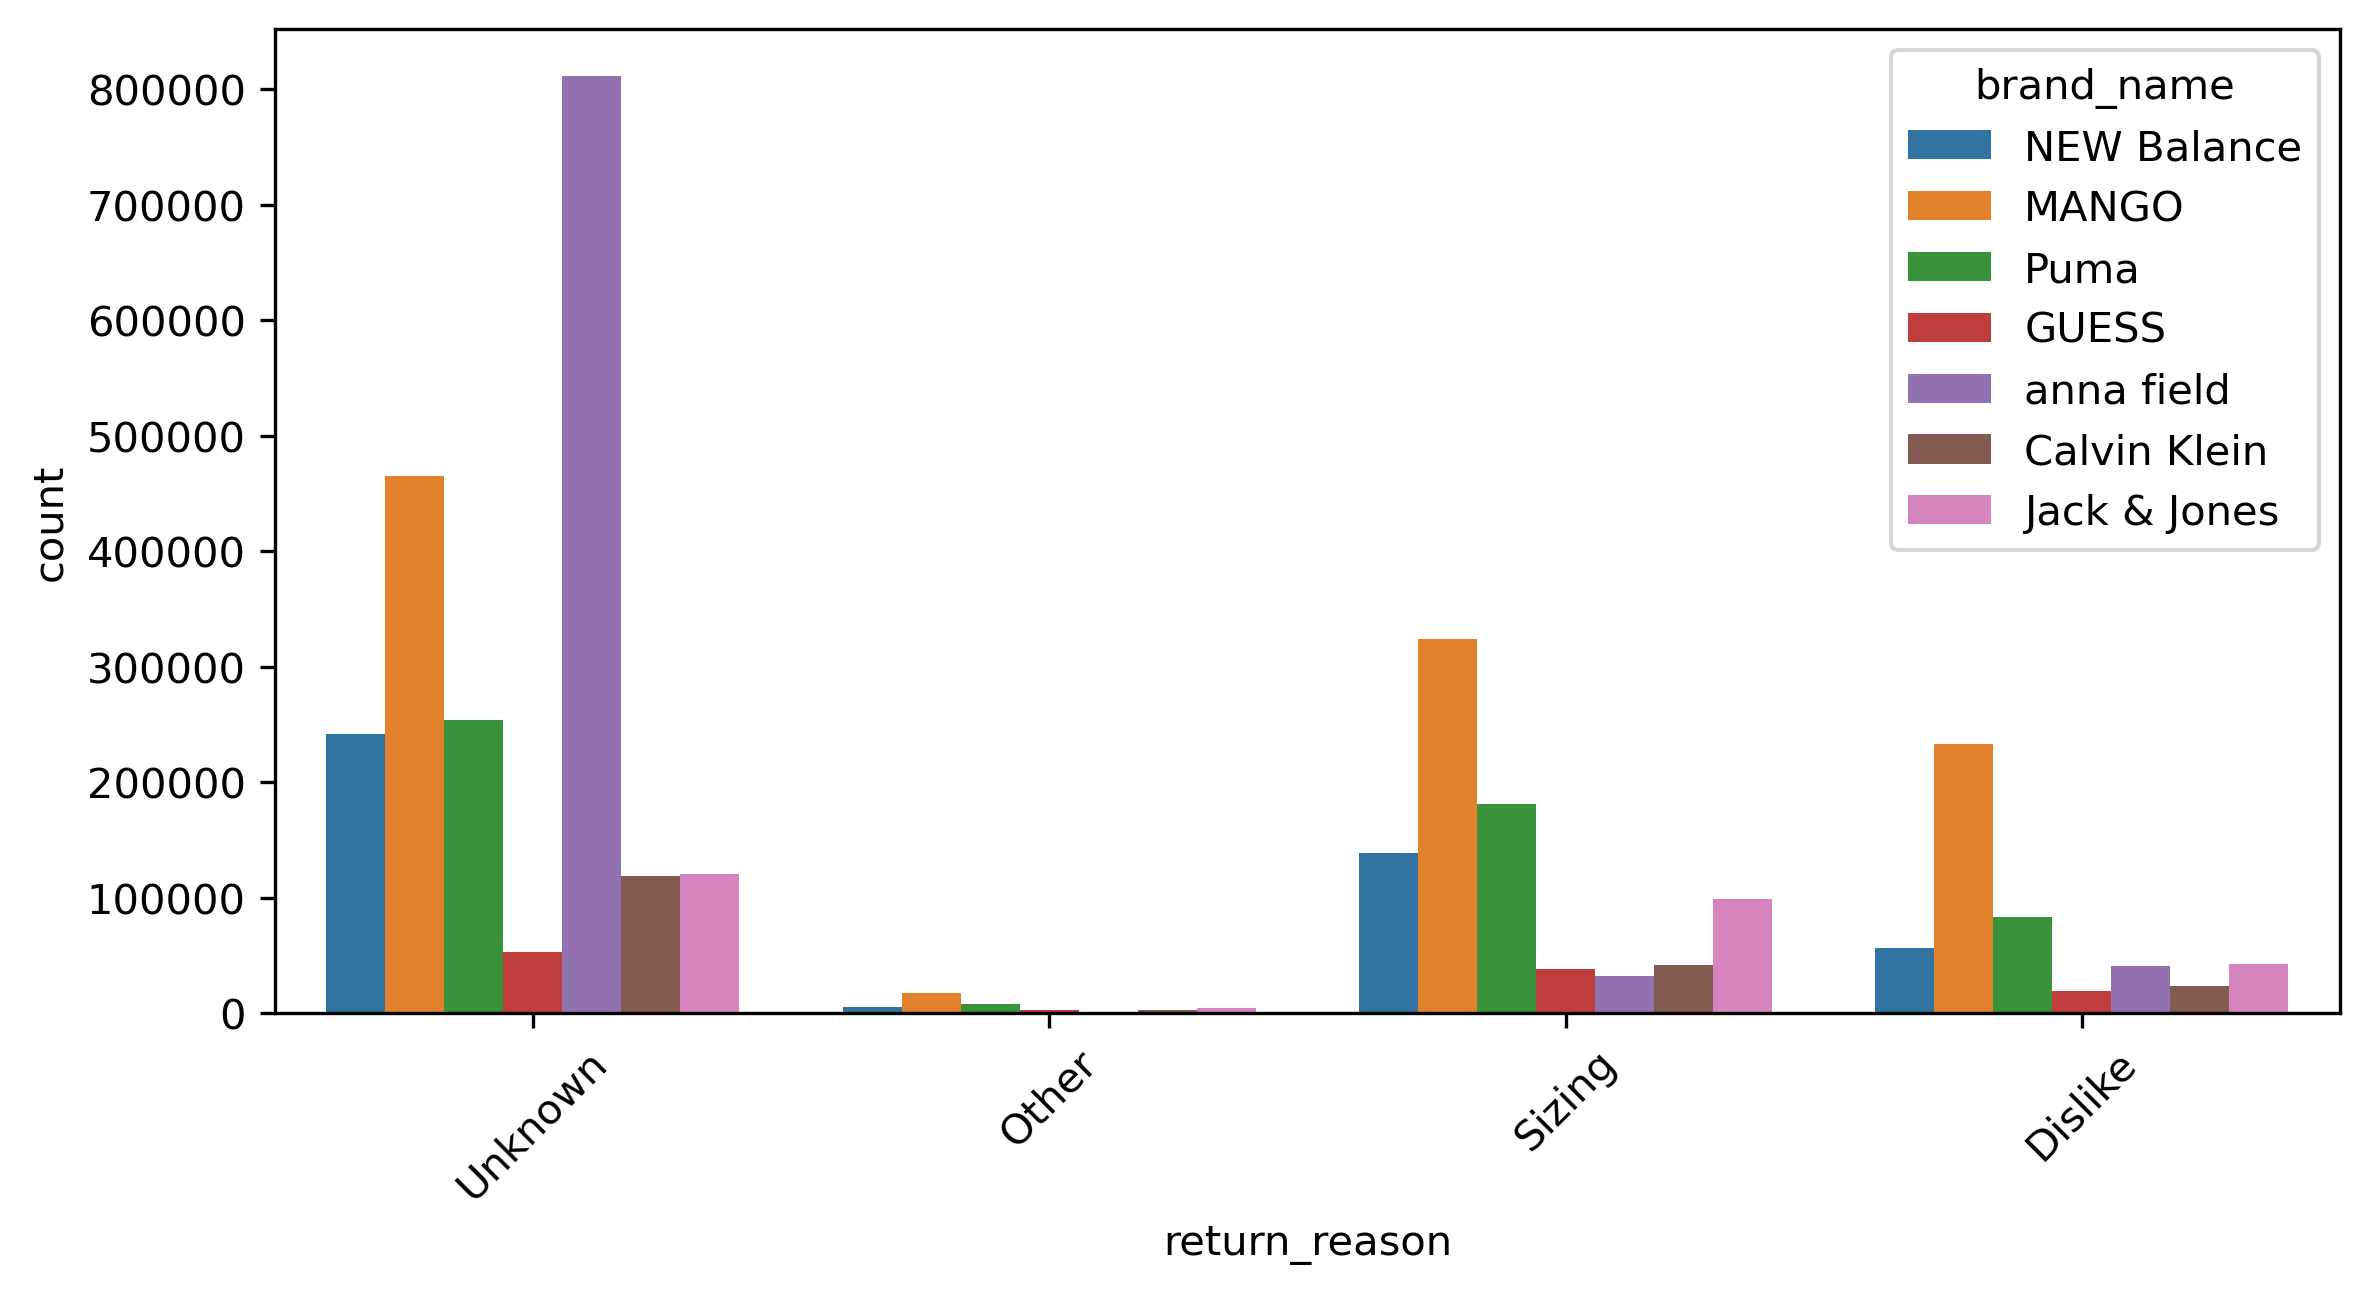

In [ ]:
plt.figure(figsize=(8,4),dpi=300)
sns.countplot(data=df, x='return_reason', hue='brand_name')
plt.tight_layout()
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'NEW Balance'),
  Text(1, 0, 'MANGO'),
  Text(2, 0, 'Puma'),
  Text(3, 0, 'GUESS'),
  Text(4, 0, 'anna field'),
  Text(5, 0, 'Calvin Klein'),
  Text(6, 0, 'Jack & Jones')])

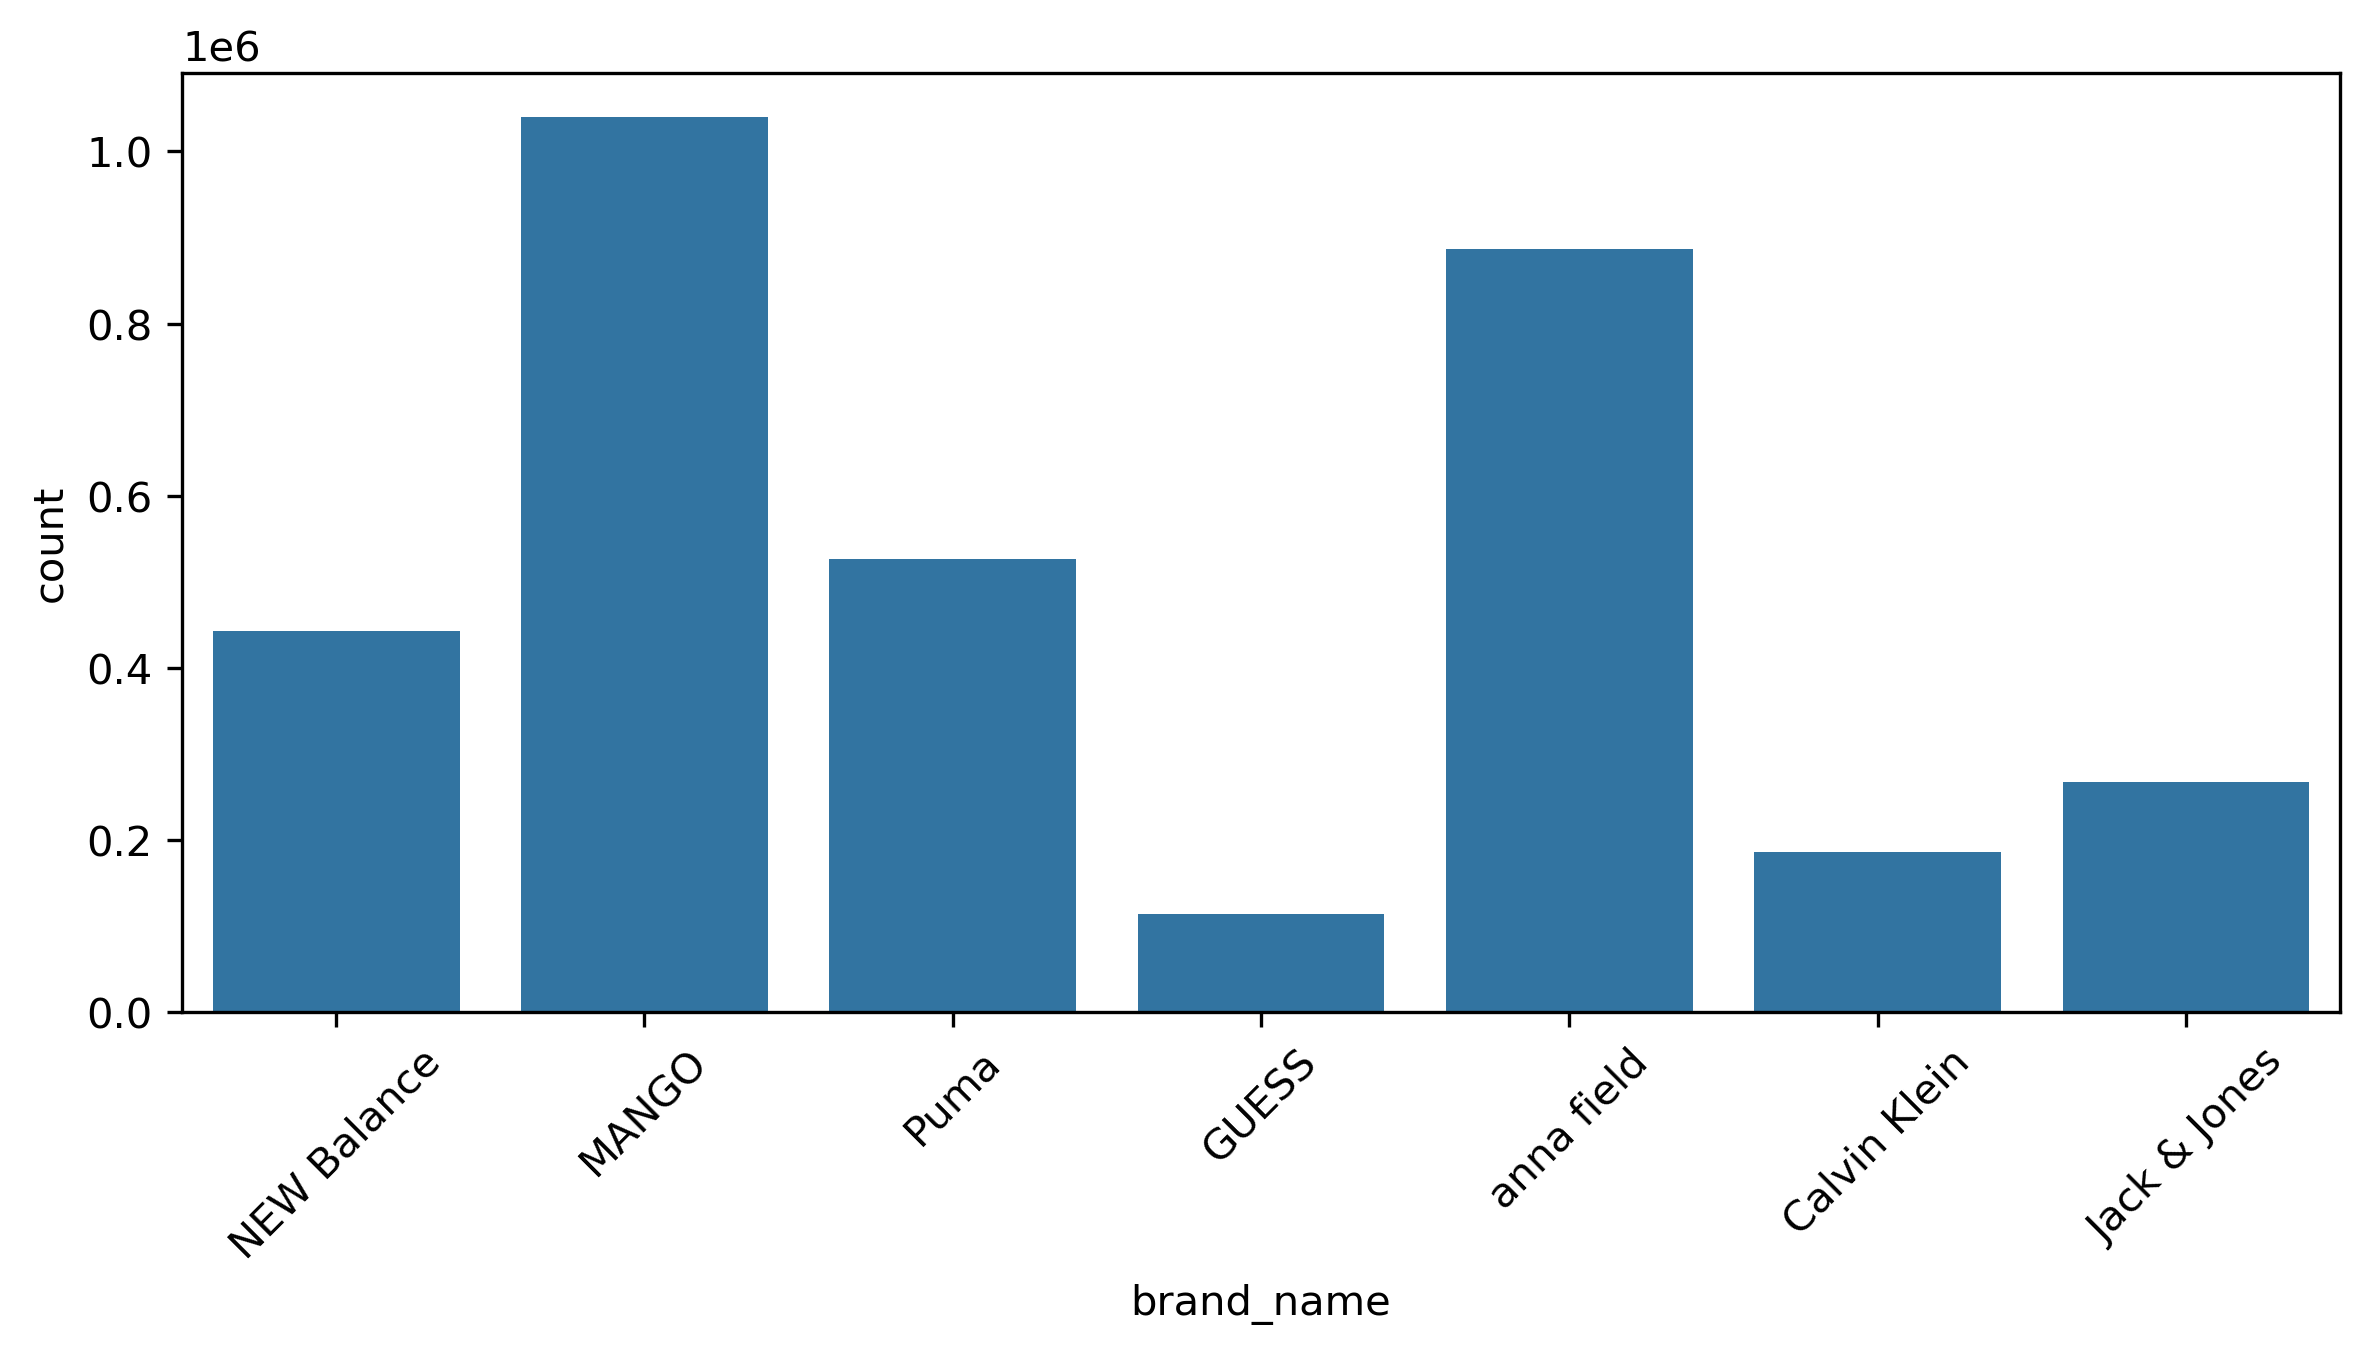

In [ ]:
plt.figure(figsize=(8,4),dpi=300)
sns.countplot(data=df, x='brand_name')
plt.tight_layout()
plt.xticks(rotation=45)

In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64'])

In [ ]:
corr_matrix = numeric_cols.corr()

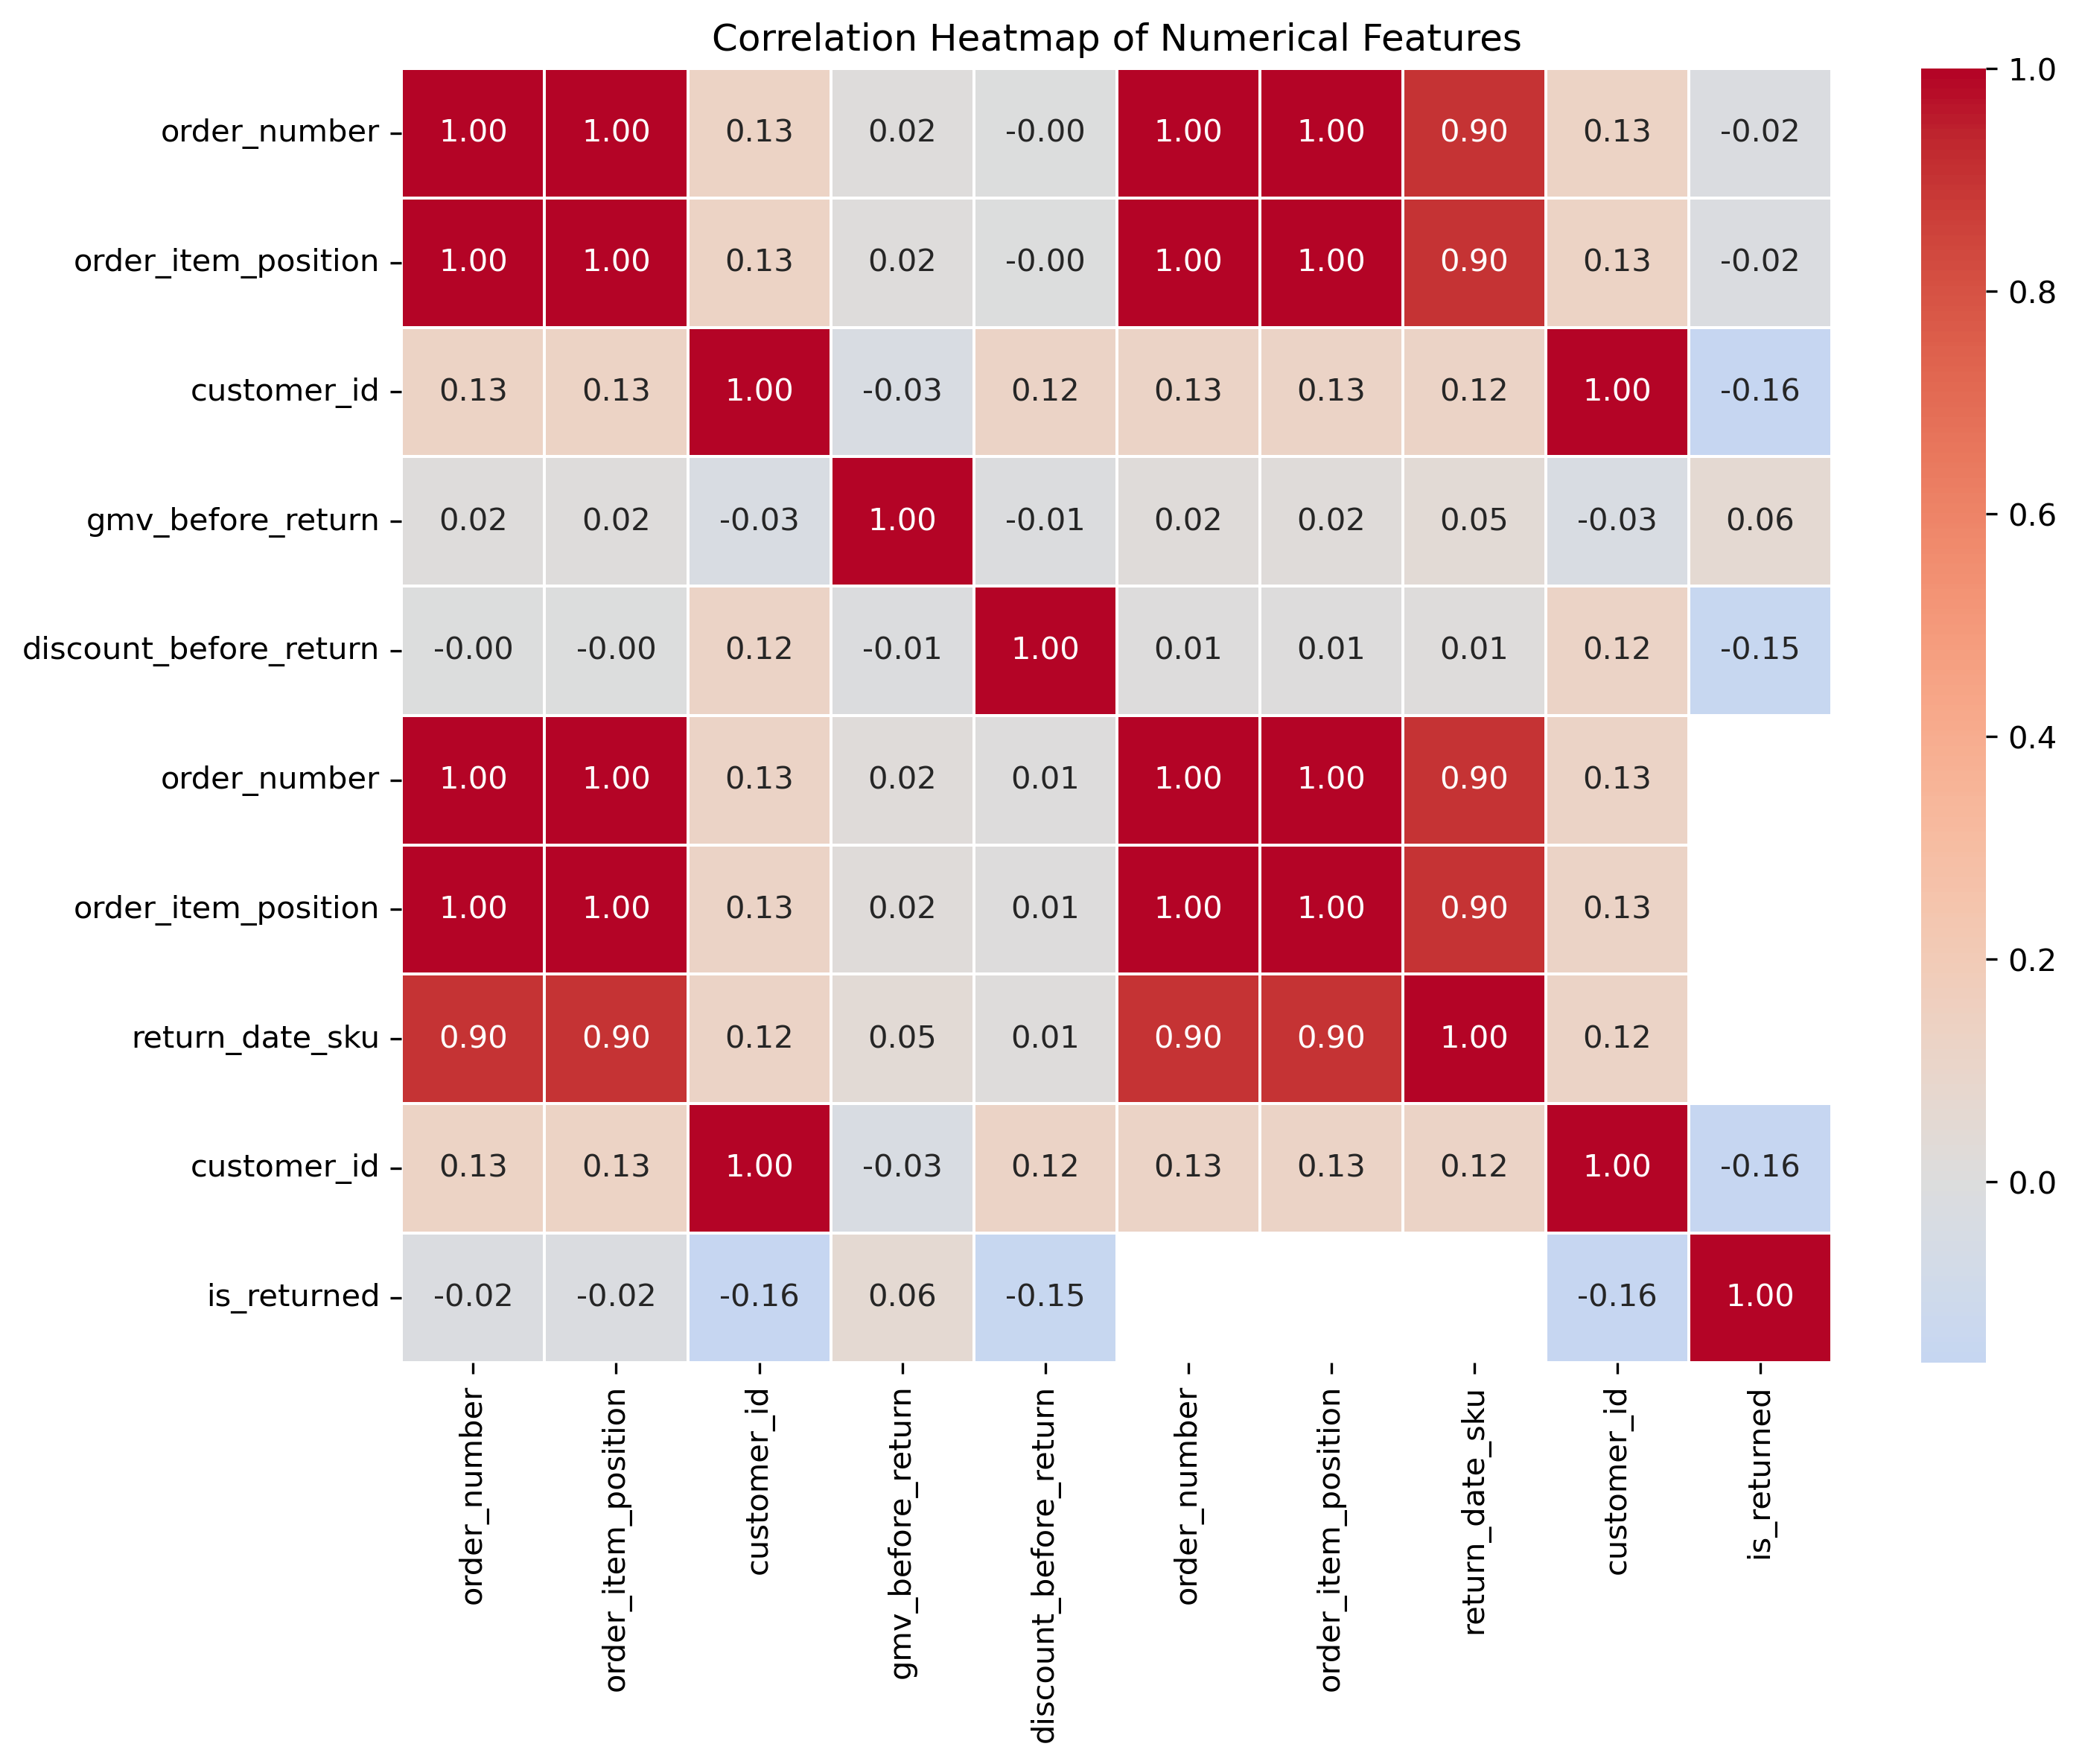

In [ ]:
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, center=0)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

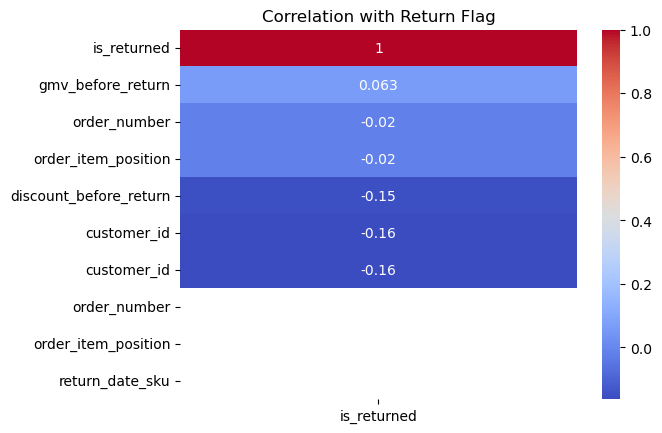

In [ ]:
target_corr = corr_matrix[['is_returned']].sort_values(by='is_returned', ascending=False)
sns.heatmap(target_corr, annot=True, cmap='coolwarm')
plt.title("Correlation with Return Flag")
plt.show()

([0, 1, 2, 3, 4],
 [Text(0, 0, 'France'),
  Text(1, 0, 'Germany'),
  Text(2, 0, 'Sweden'),
  Text(3, 0, 'Italy'),
  Text(4, 0, 'Switzerland')])

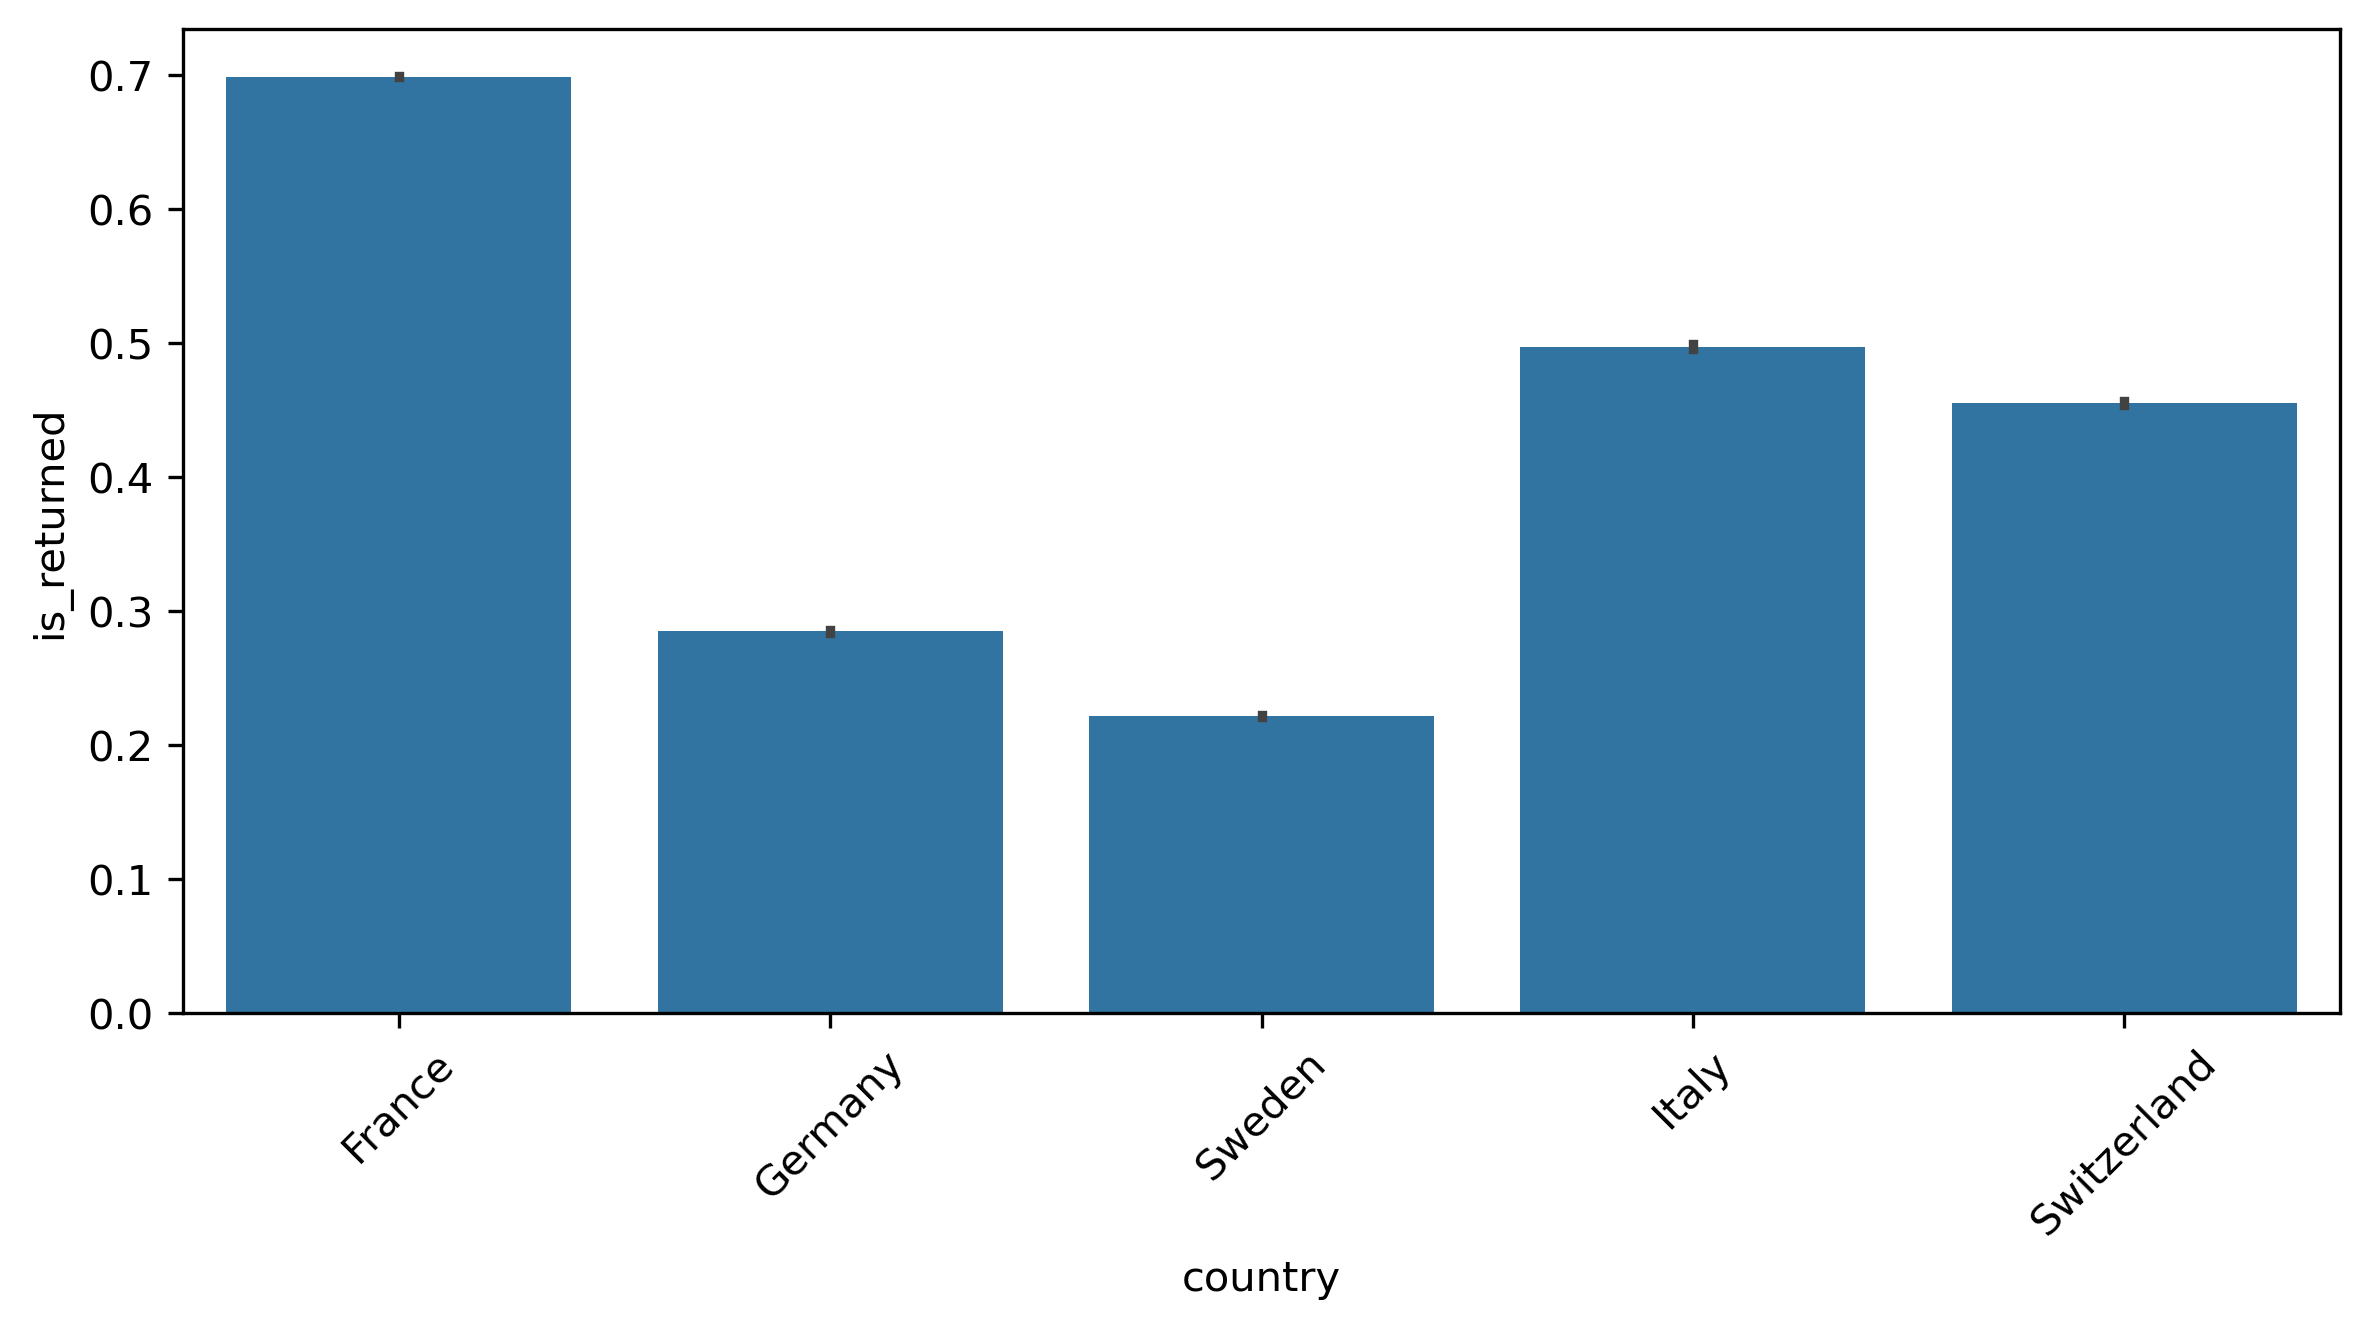

In [ ]:
plt.figure(figsize=(8,4),dpi=300)
sns.barplot(data=df, x='country', y='is_returned')
plt.tight_layout()
plt.xticks(rotation=45)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'France'),
  Text(1, 0, 'Germany'),
  Text(2, 0, 'Sweden'),
  Text(3, 0, 'Italy'),
  Text(4, 0, 'Switzerland')])

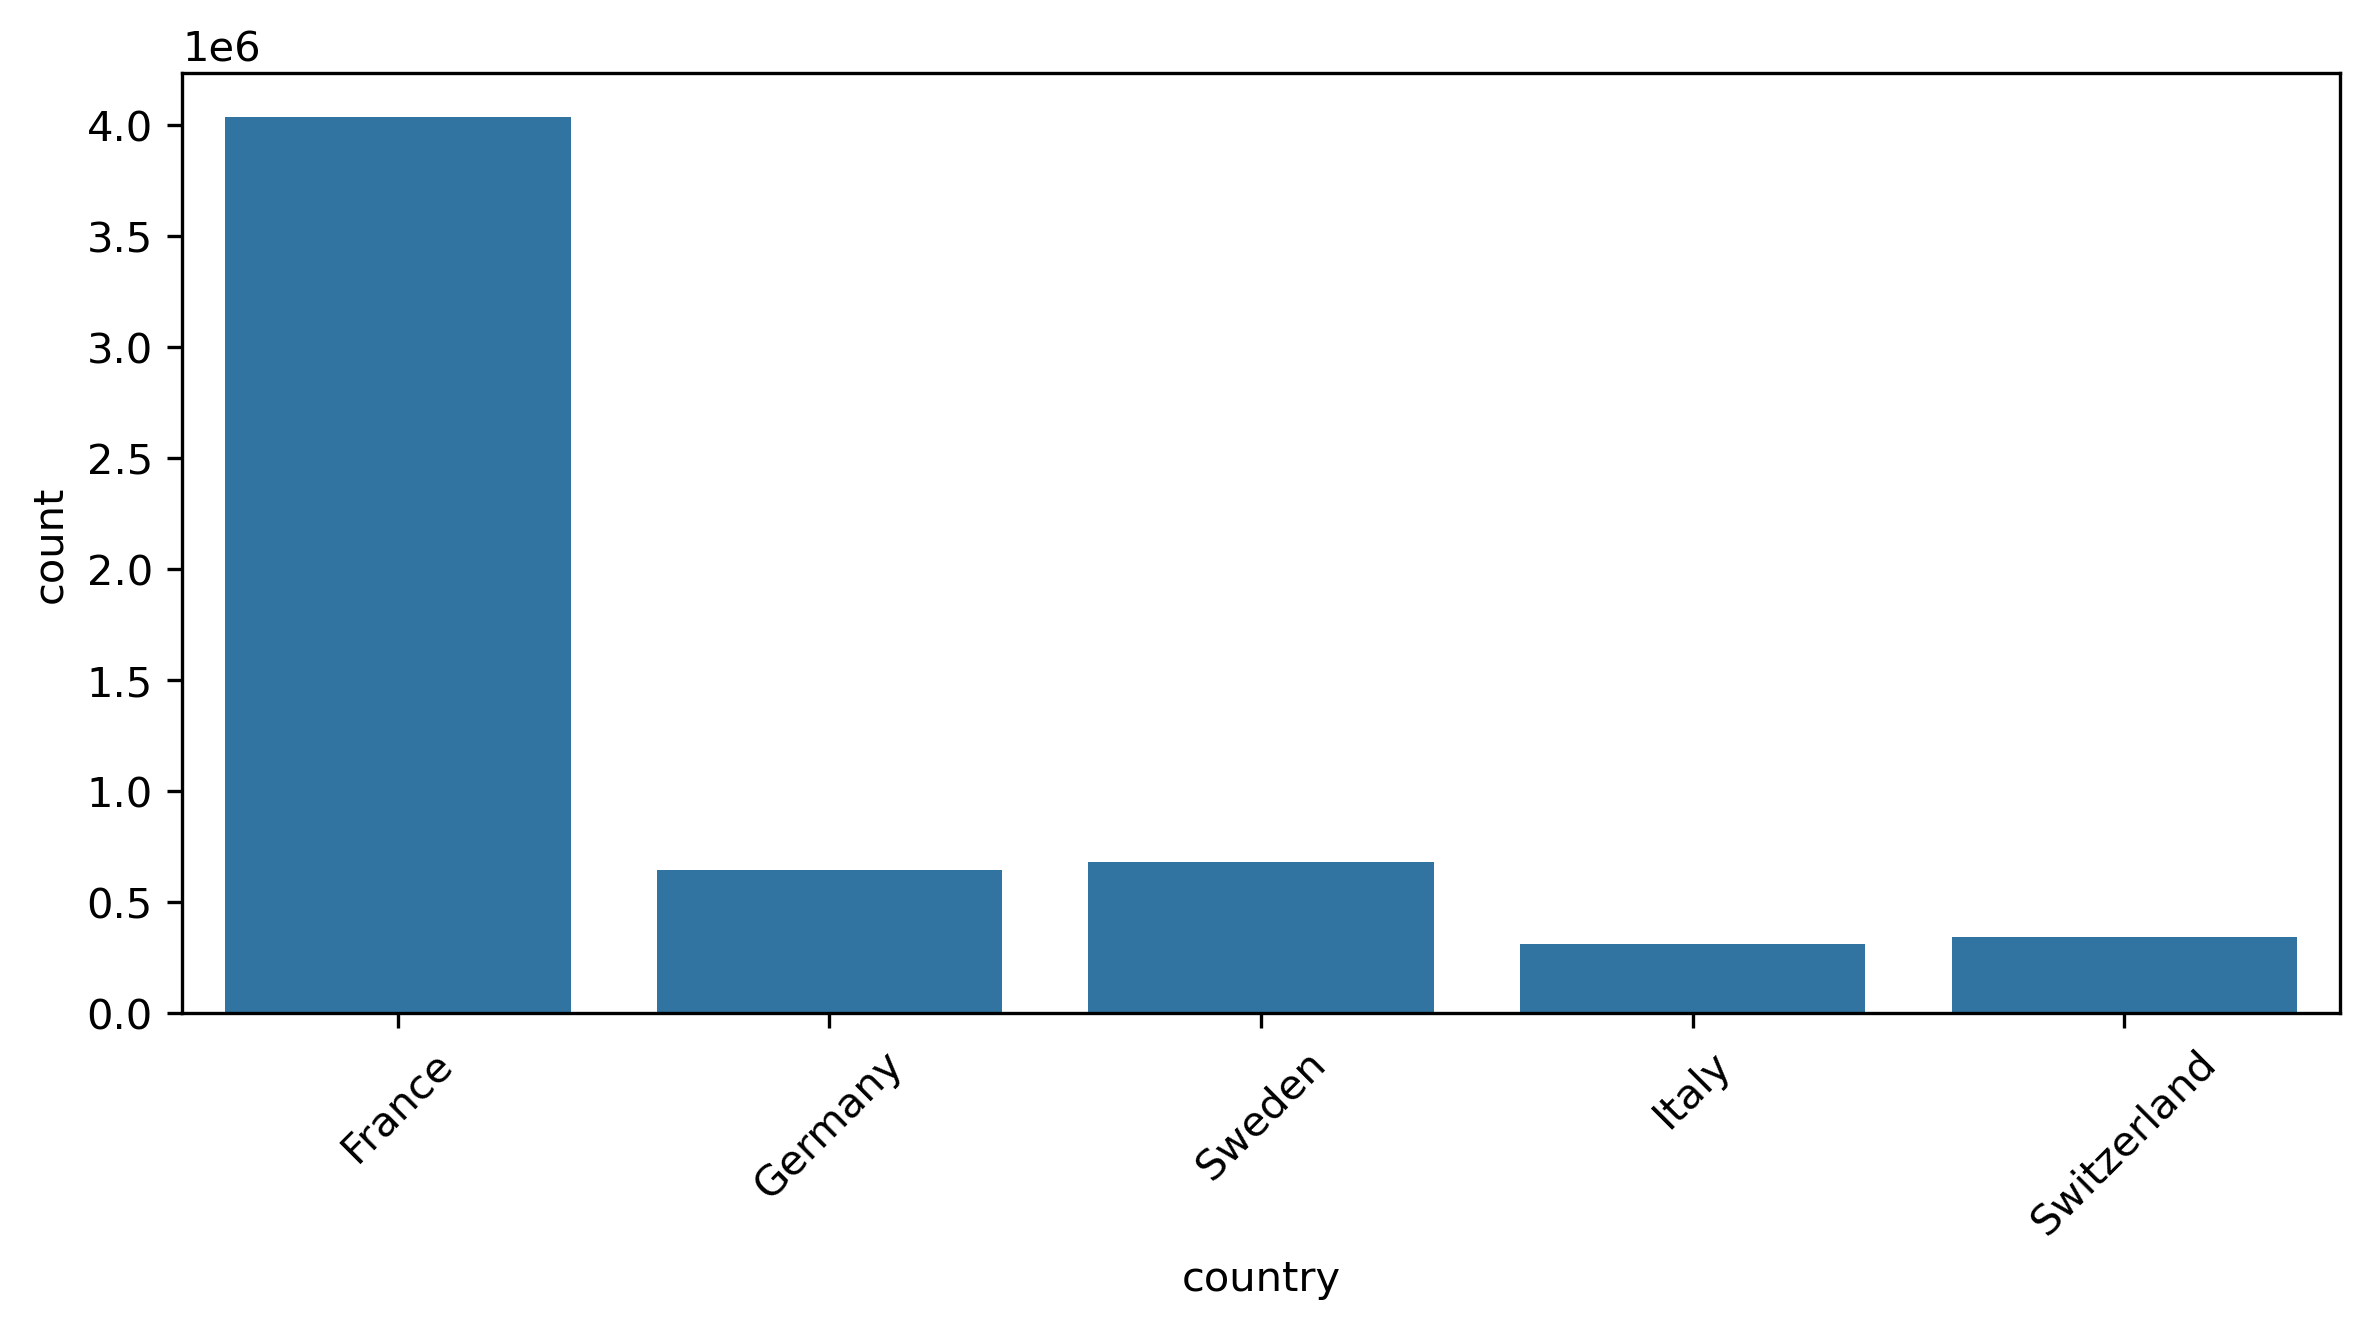

In [ ]:
plt.figure(figsize=(8,4),dpi=300)
sns.countplot(data=df, x='country')
plt.tight_layout()
plt.xticks(rotation=45)

In [ ]:
reason_brand_counts = (
    df.groupby(['return_reason', 'brand_name'])
      .size()
      .reset_index(name='count')
)
top3_per_reason = (
    reason_brand_counts
    .sort_values(['return_reason', 'count'], ascending=[True, False])
    .groupby('return_reason')
    .head(3)
)

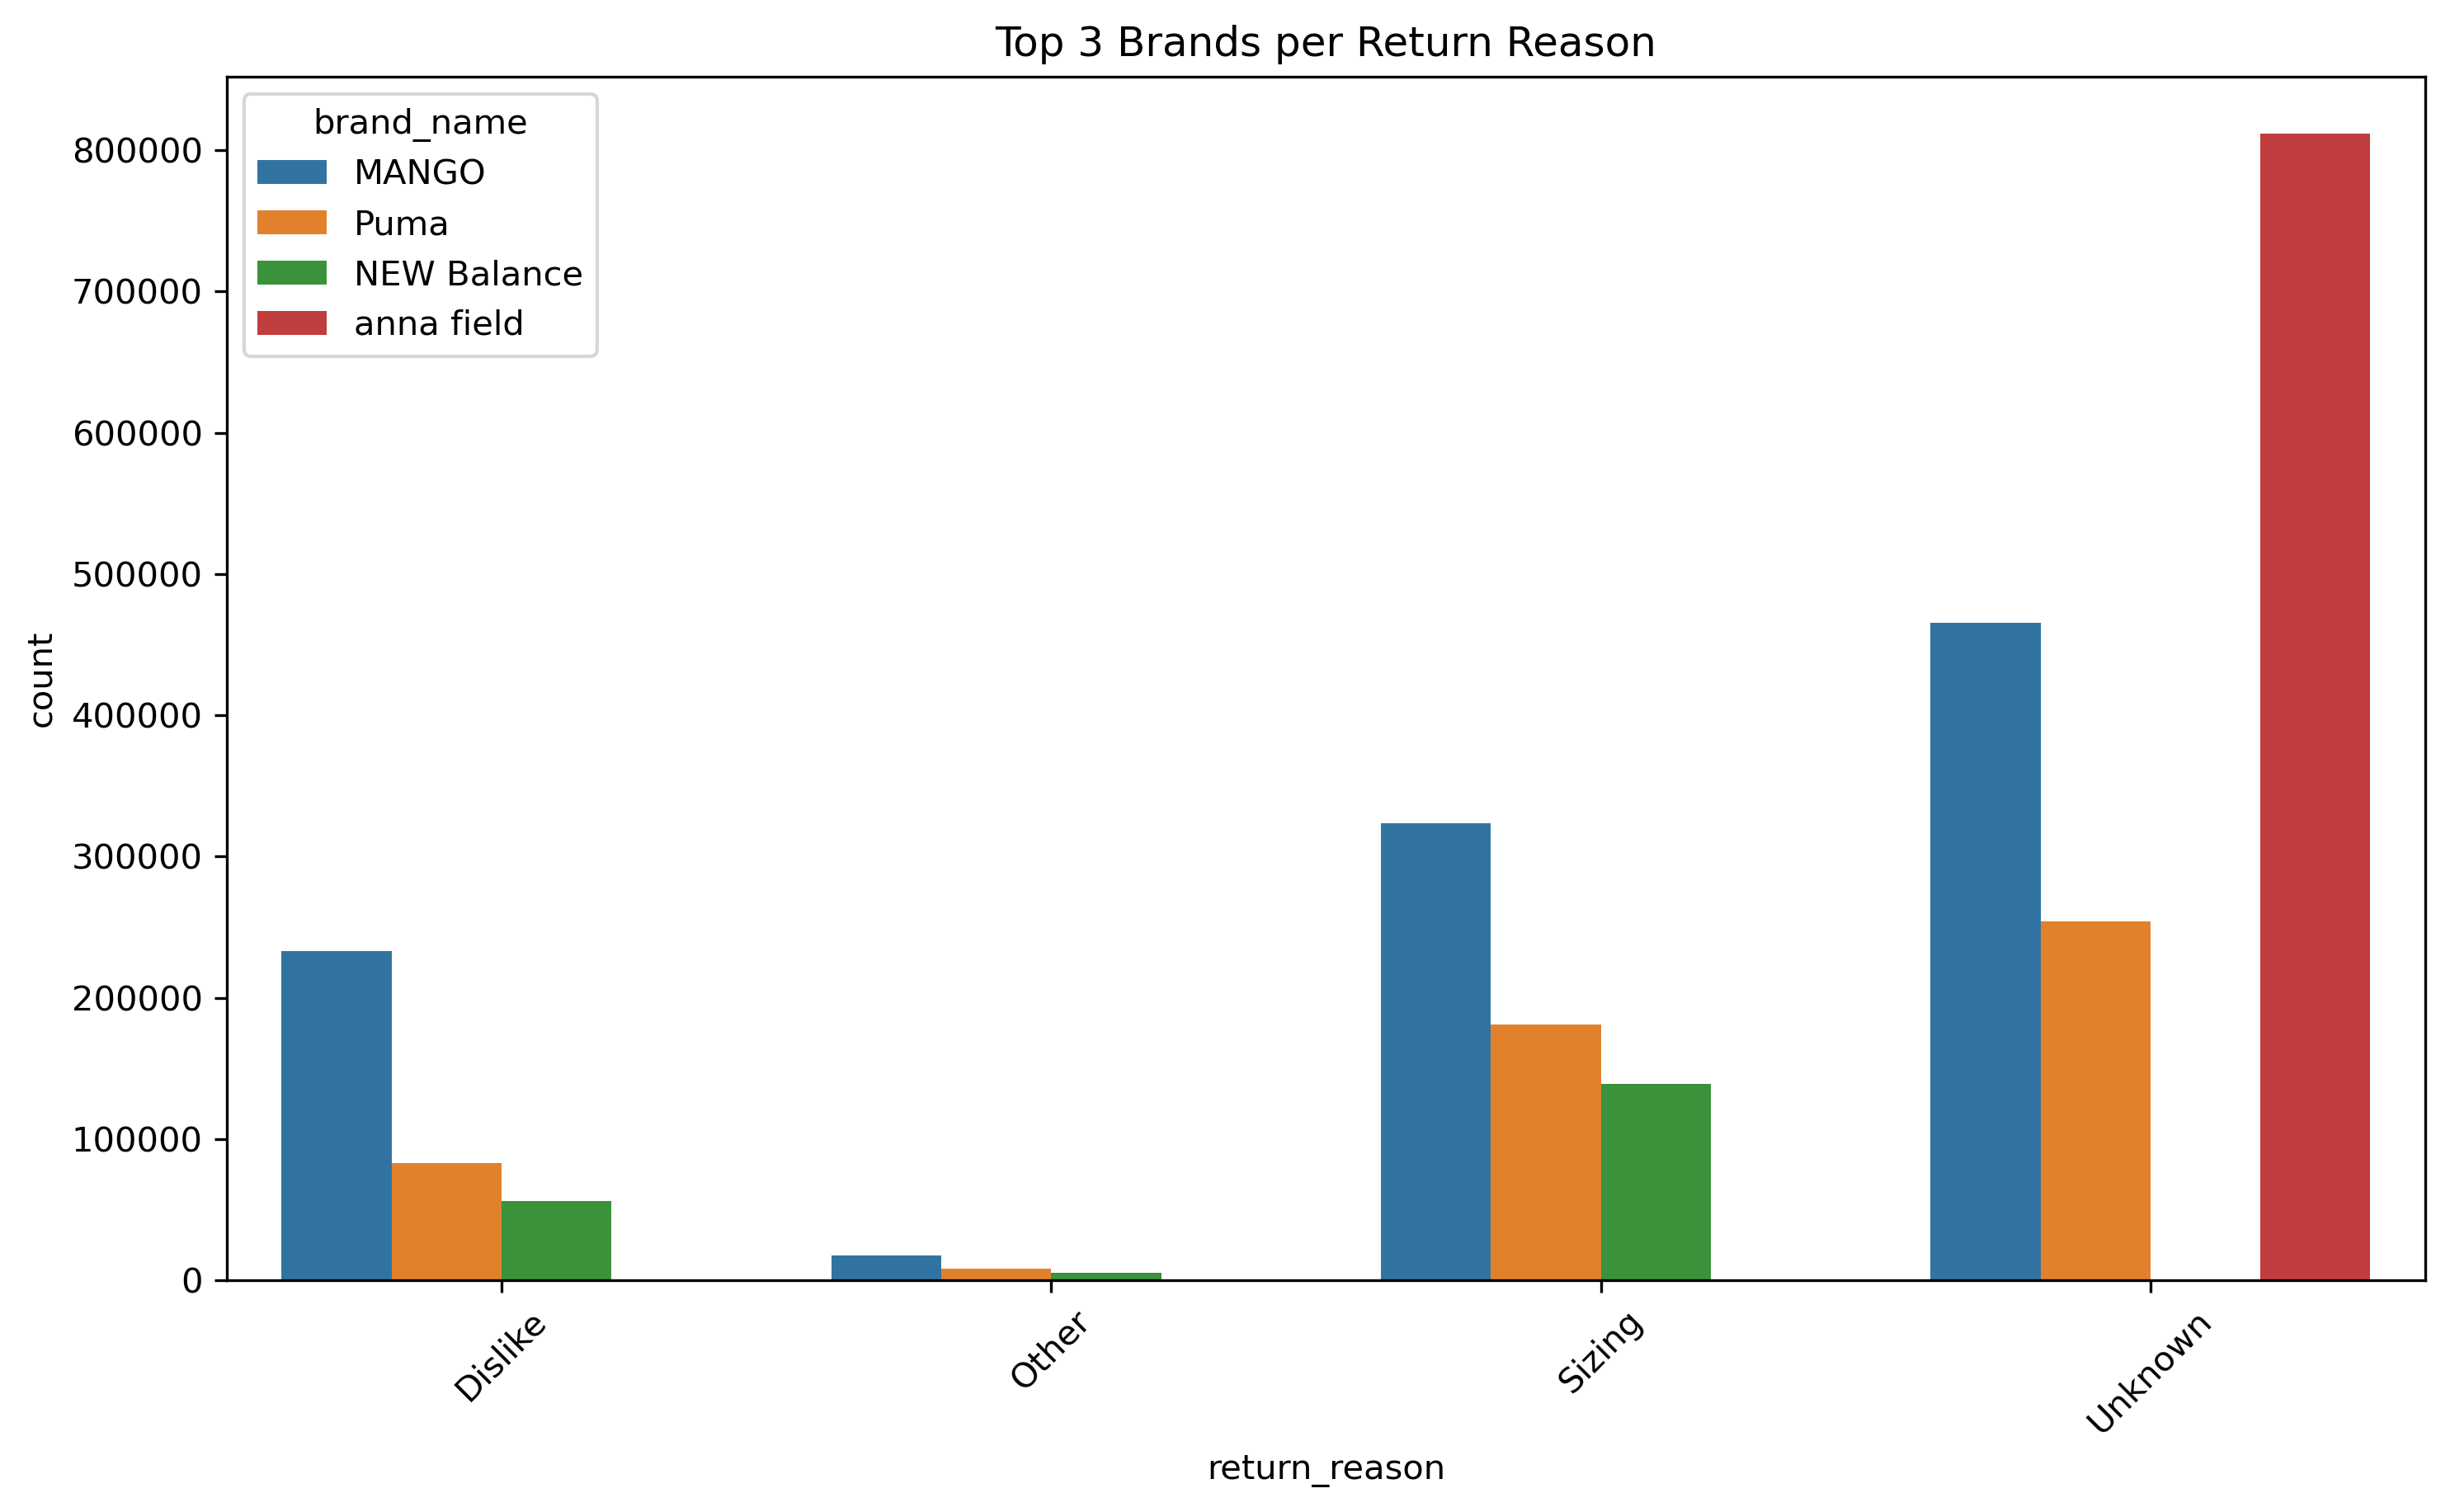

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(
    data=top3_per_reason,
    x='return_reason',
    y='count',
    hue='brand_name'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.title("Top 3 Brands per Return Reason")
plt.show()

([0, 1], [Text(0, 0, '0'), Text(1, 0, '1')])

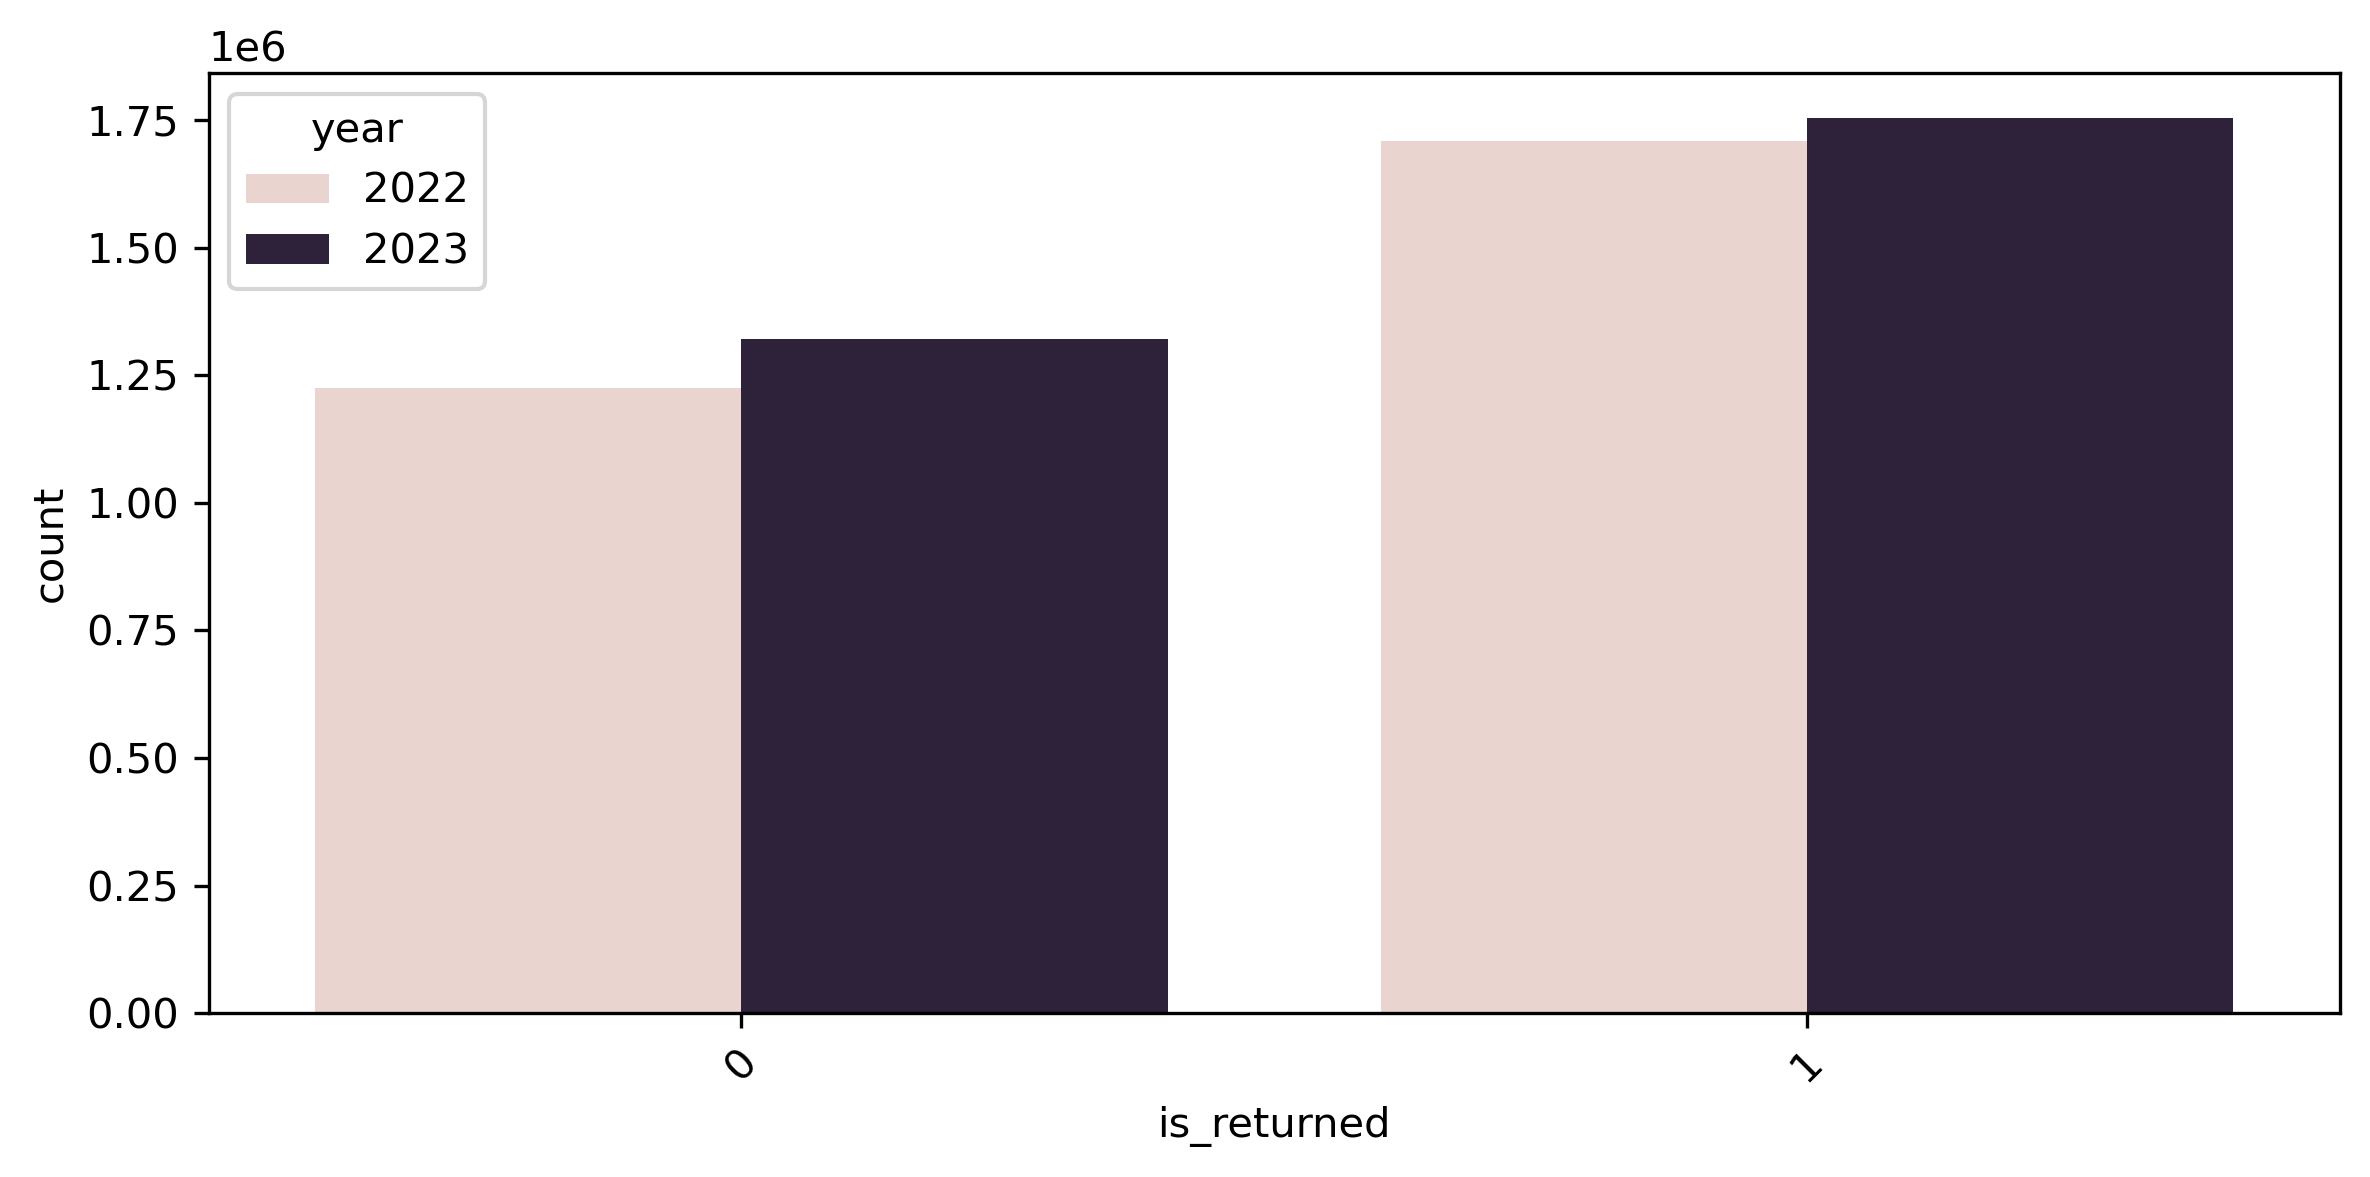

In [ ]:
plt.figure(figsize=(8,4),dpi=300)
sns.countplot(data=df, x='is_returned', hue='year')
plt.tight_layout()
plt.xticks(rotation=45)

In [ ]:
returned_df = df[df['is_returned'] == 1]

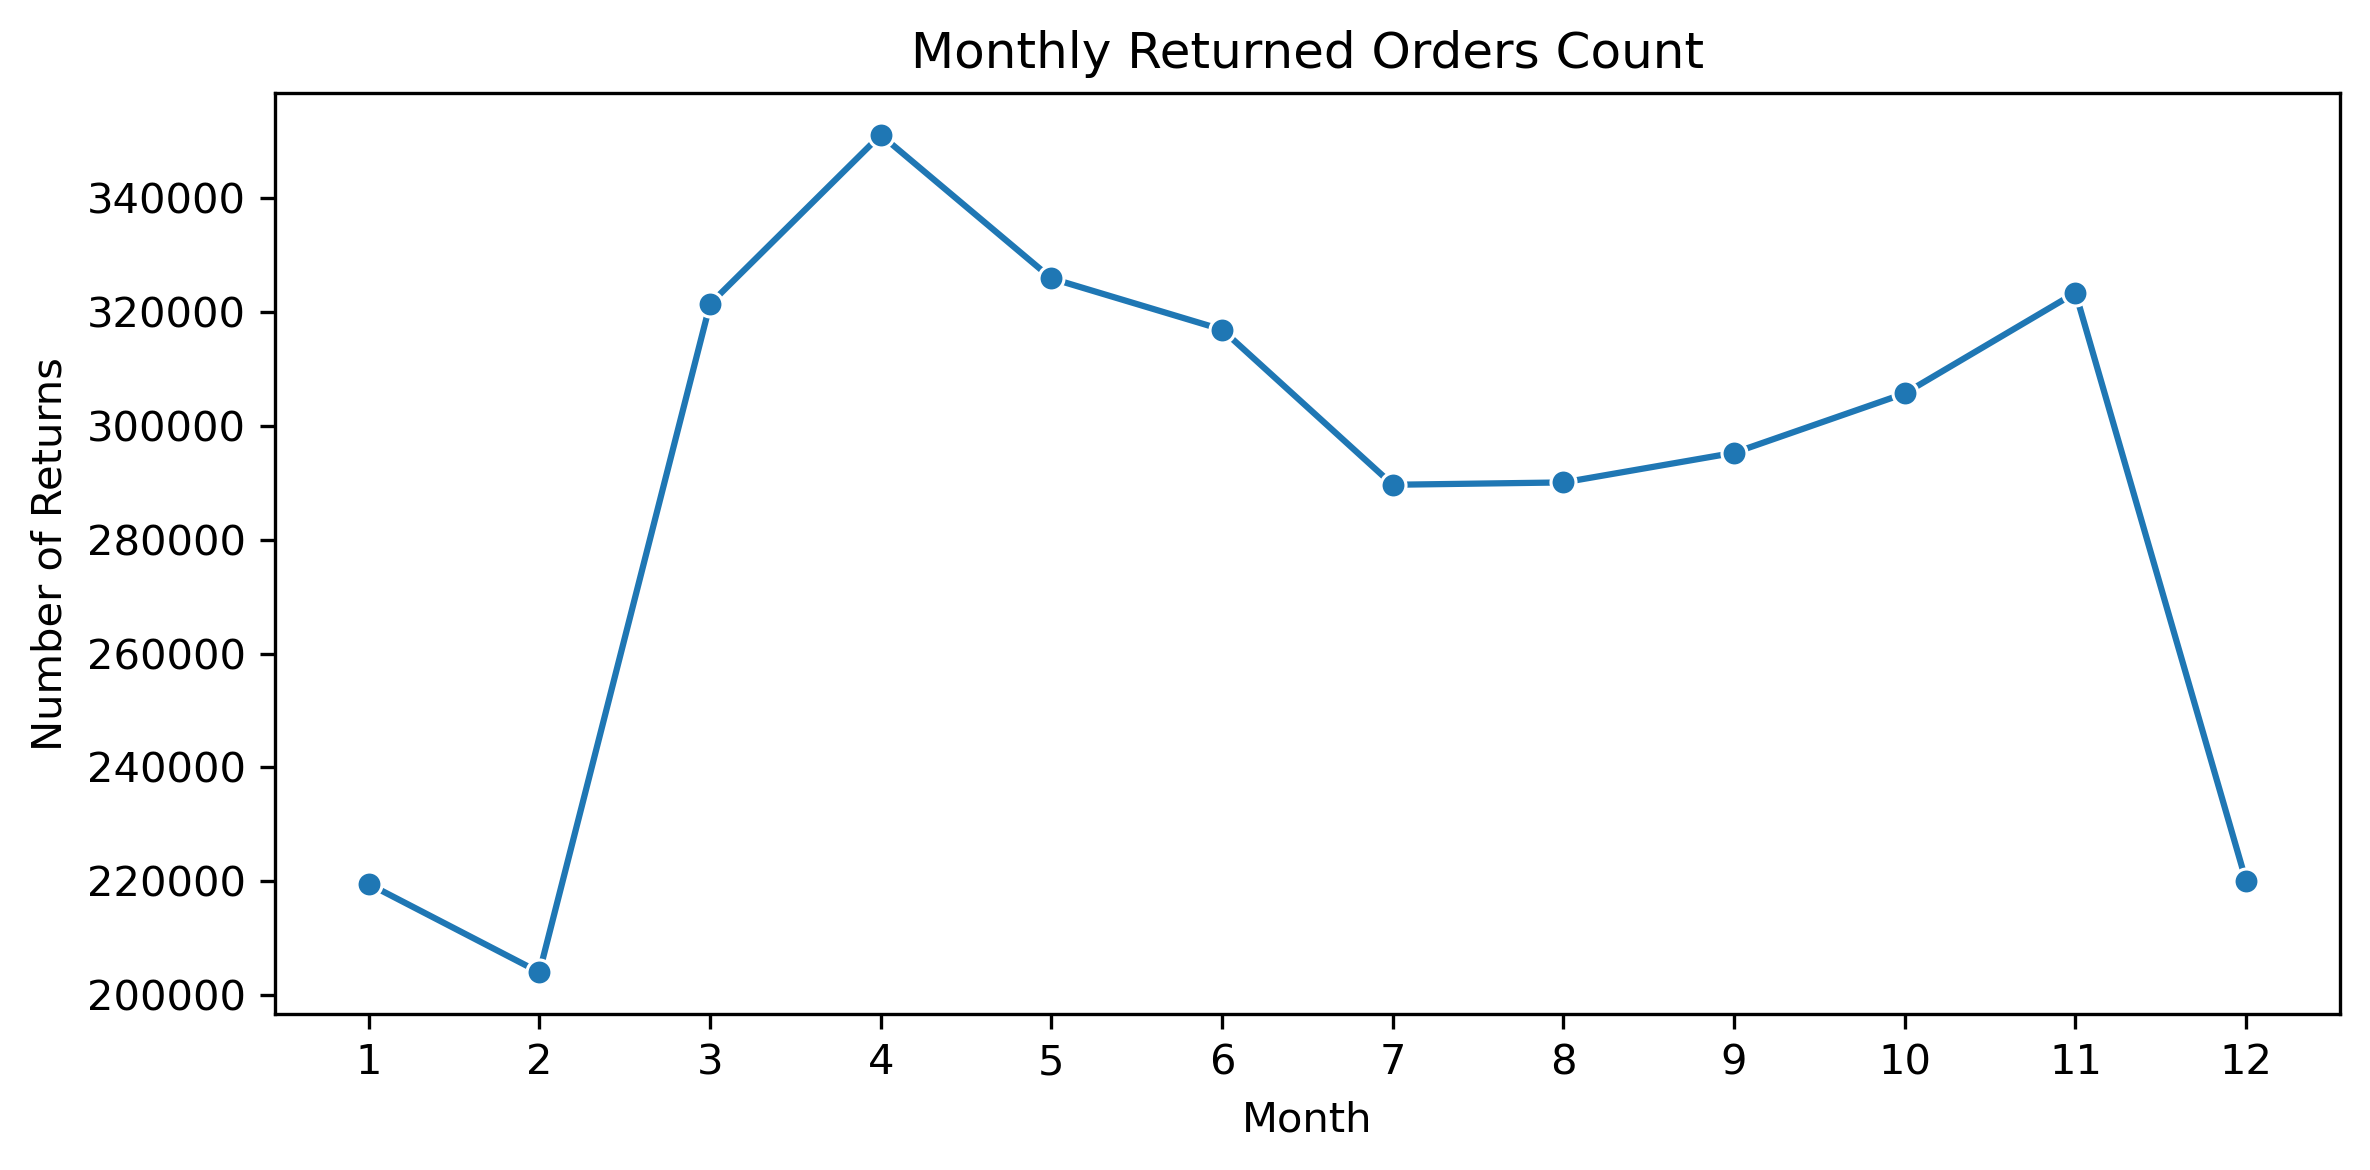

In [ ]:


grouped_month = returned_df.groupby('month').size().reset_index(name='count')

plt.figure(figsize=(8,4), dpi=300)
sns.lineplot(data=grouped_month, x='month', y='count', marker='o')
plt.title('Monthly Returned Orders Count')
plt.xlabel('Month')
plt.ylabel('Number of Returns')
plt.xticks(range(1, 13))
plt.tight_layout()

In [ ]:
returned_df.head()

,order_number,order_item_position,config_sku,size_sku,customer_id,order_date,gmv_before_return,discount_before_return,order_number,order_item_position,simple_sku,return_date_sku,return_reason,customer_id,customer_gender,country,customer_quality,simple_sku,config_sku,article_size,product_category,brand_name,is_returned,year,month,day,day_of_week
2,330818553,930351730,APU111S06U-Q11,0007000,317213832,2022-01-01,59.95,40.0,330818553.0,930351730.0,APU111S06U-Q110007000,20220115.0,Unknown,317213832,Women,France,3,APU111S06U-Q110007000,APU111S06U-Q11,40.5,Sneakers,NEW Balance,1,2022,1,1,5
3,330818553,930351731,APU111S06U-Q11,0065000,317213832,2022-01-01,59.95,40.0,330818553.0,930351731.0,APU111S06U-Q110065000,20220115.0,Unknown,317213832,Women,France,3,APU111S06U-Q110065000,APU111S06U-Q11,40,Sneakers,NEW Balance,1,2022,1,1,5
7,330820206,930386843,XAN621CAIB-Q11,0044000,43591638,2022-01-01,24.95,25.0,330820206.0,930386843.0,XAN621CAIB-Q110044000,20220110.0,Unknown,43591638,Women,France,4,XAN621CAIB-Q110044000,XAN621CAIB-Q11,44,Dresses,MANGO,1,2022,1,1,5
12,330820400,930366860,BNE211S05A-C11,0013000,15351539,2022-01-01,87.95,22.0,330820400.0,930366860.0,BNE211S05A-C110013000,20220117.0,Other,15351539,Women,France,2,BNE211S05A-C110013000,BNE211S05A-C11,40.5,Sneakers,Puma,1,2022,1,1,5
15,330820561,930366974,APU111S06F-D11,0075000,34114679,2022-01-01,95.95,24.0,330820561.0,930366974.0,APU111S06F-D110075000,20220115.0,Unknown,34114679,Women,France,1,APU111S06F-D110075000,APU111S06F-D11,41,Sneakers,NEW Balance,1,2022,1,1,5


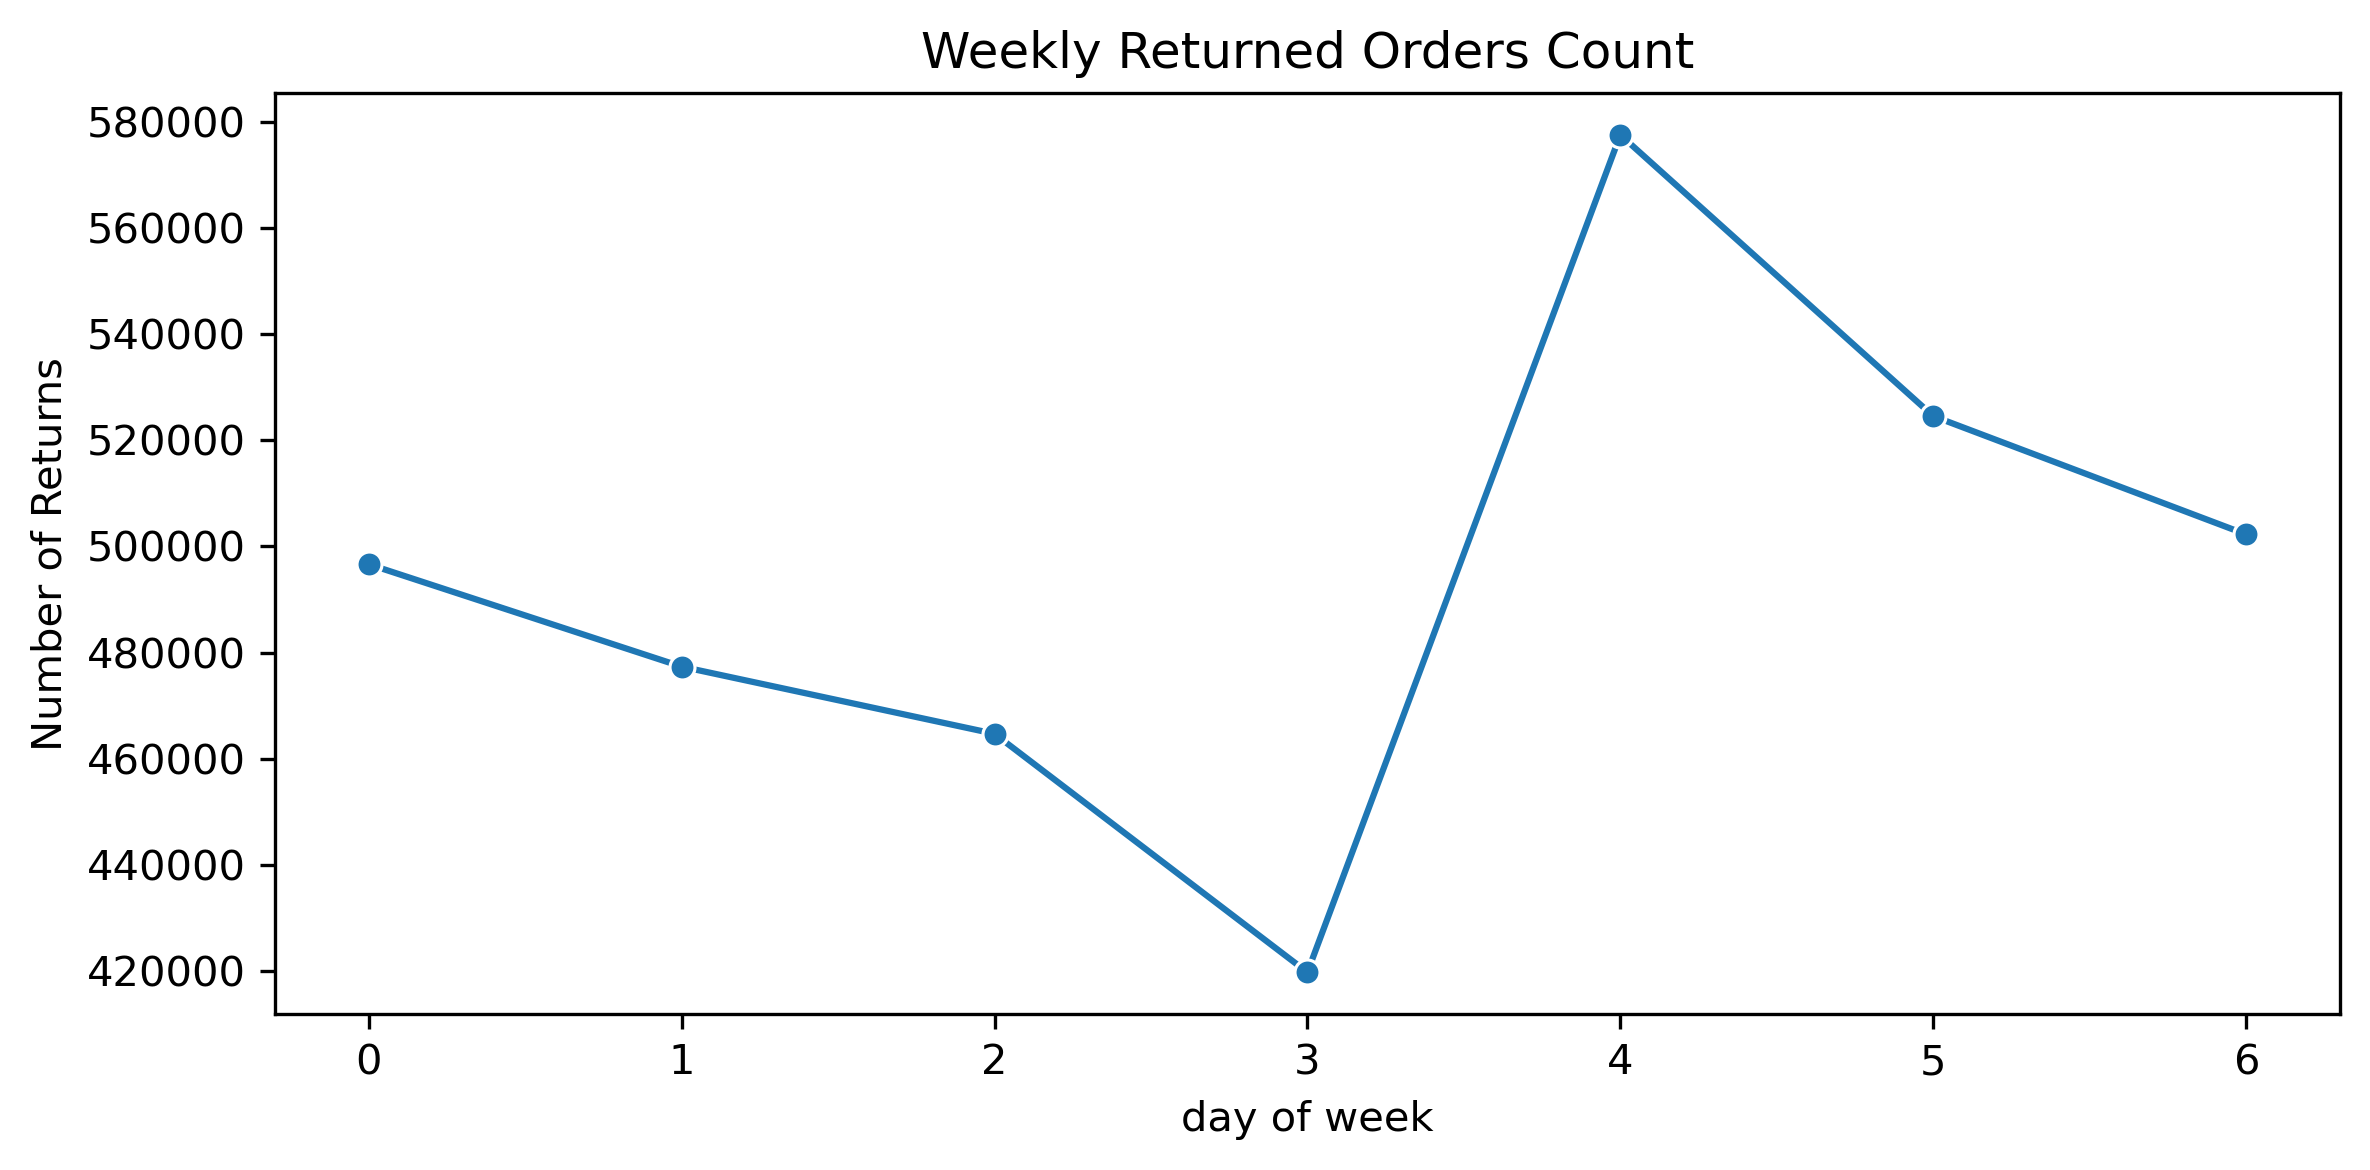

In [ ]:
grouped_week = returned_df.groupby('day_of_week').size().reset_index(name='count')

plt.figure(figsize=(8,4), dpi=300)
sns.lineplot(data=grouped_week, x='day_of_week', y='count', marker='o')
plt.title('Weekly Returned Orders Count')
plt.xlabel('day of week')
plt.ylabel('Number of Returns')
plt.tight_layout()

([0, 1, 2], [Text(0, 0, 'Women'), Text(1, 0, 'Men'), Text(2, 0, 'Unknown')])

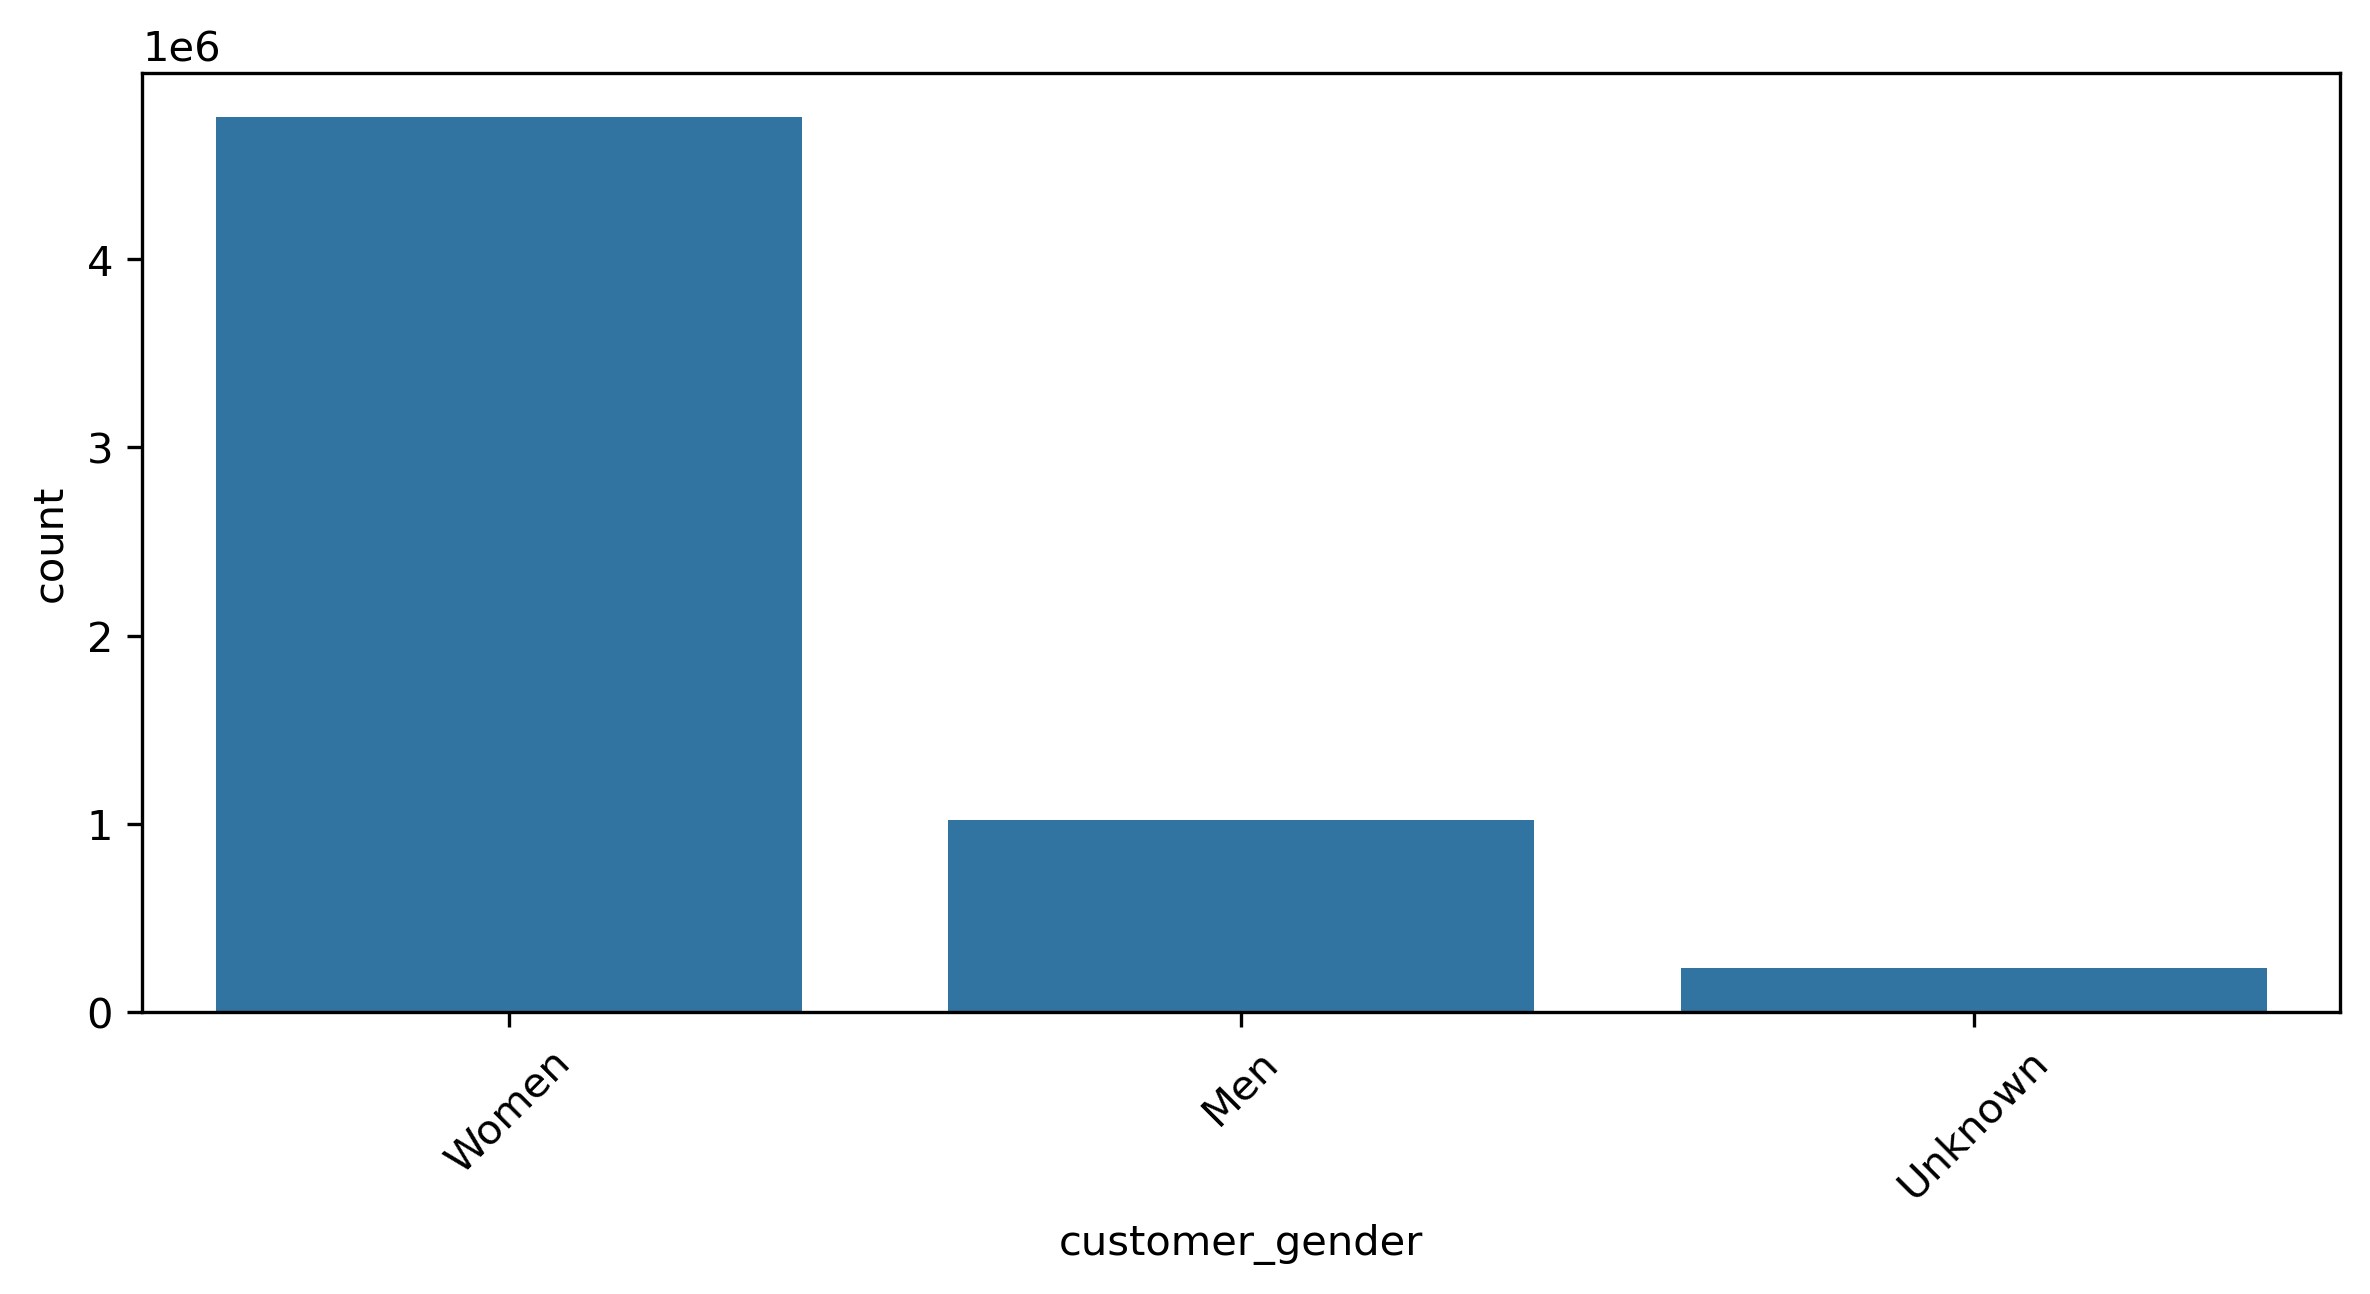

In [ ]:
plt.figure(figsize=(8,4),dpi=300)
sns.countplot(data=df, x='customer_gender')
plt.tight_layout()
plt.xticks(rotation=45)

([0, 1, 2], [Text(0, 0, 'Women'), Text(1, 0, 'Men'), Text(2, 0, 'Unknown')])

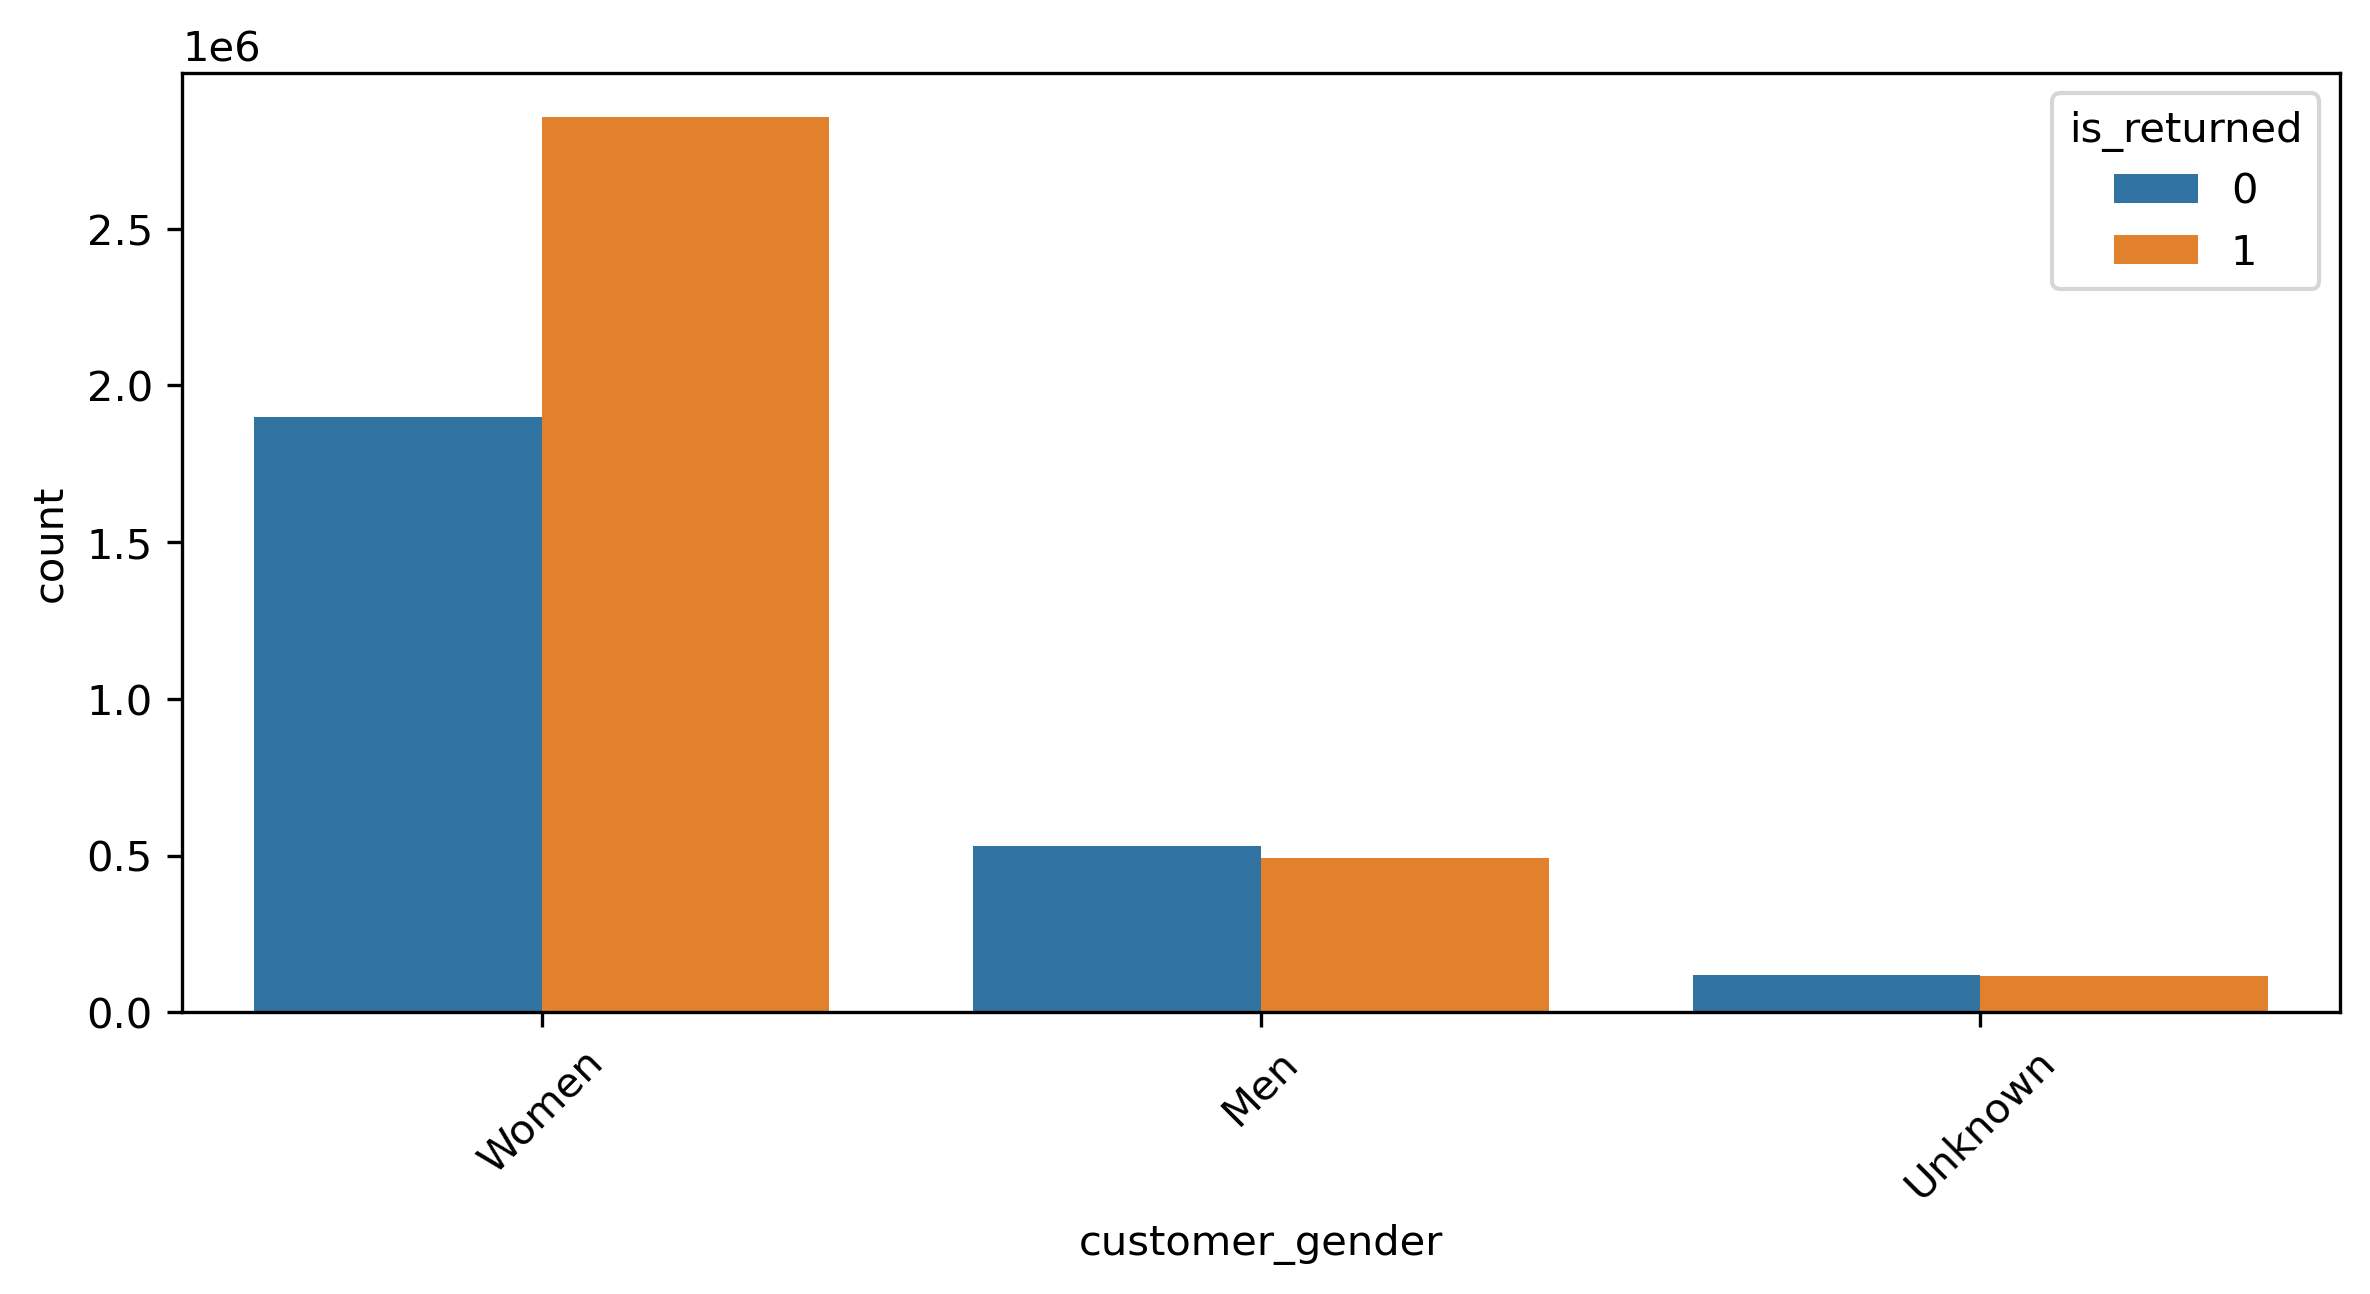

In [ ]:
plt.figure(figsize=(8,4),dpi=300)
sns.countplot(data=df, x='customer_gender', hue='is_returned')
plt.tight_layout()
plt.xticks(rotation=45)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Sneakers'),
  Text(1, 0, 'Dresses'),
  Text(2, 0, 'Jeans'),
  Text(3, 0, 'Scarves & Gloves'),
  Text(4, 0, 'Beachwear')])

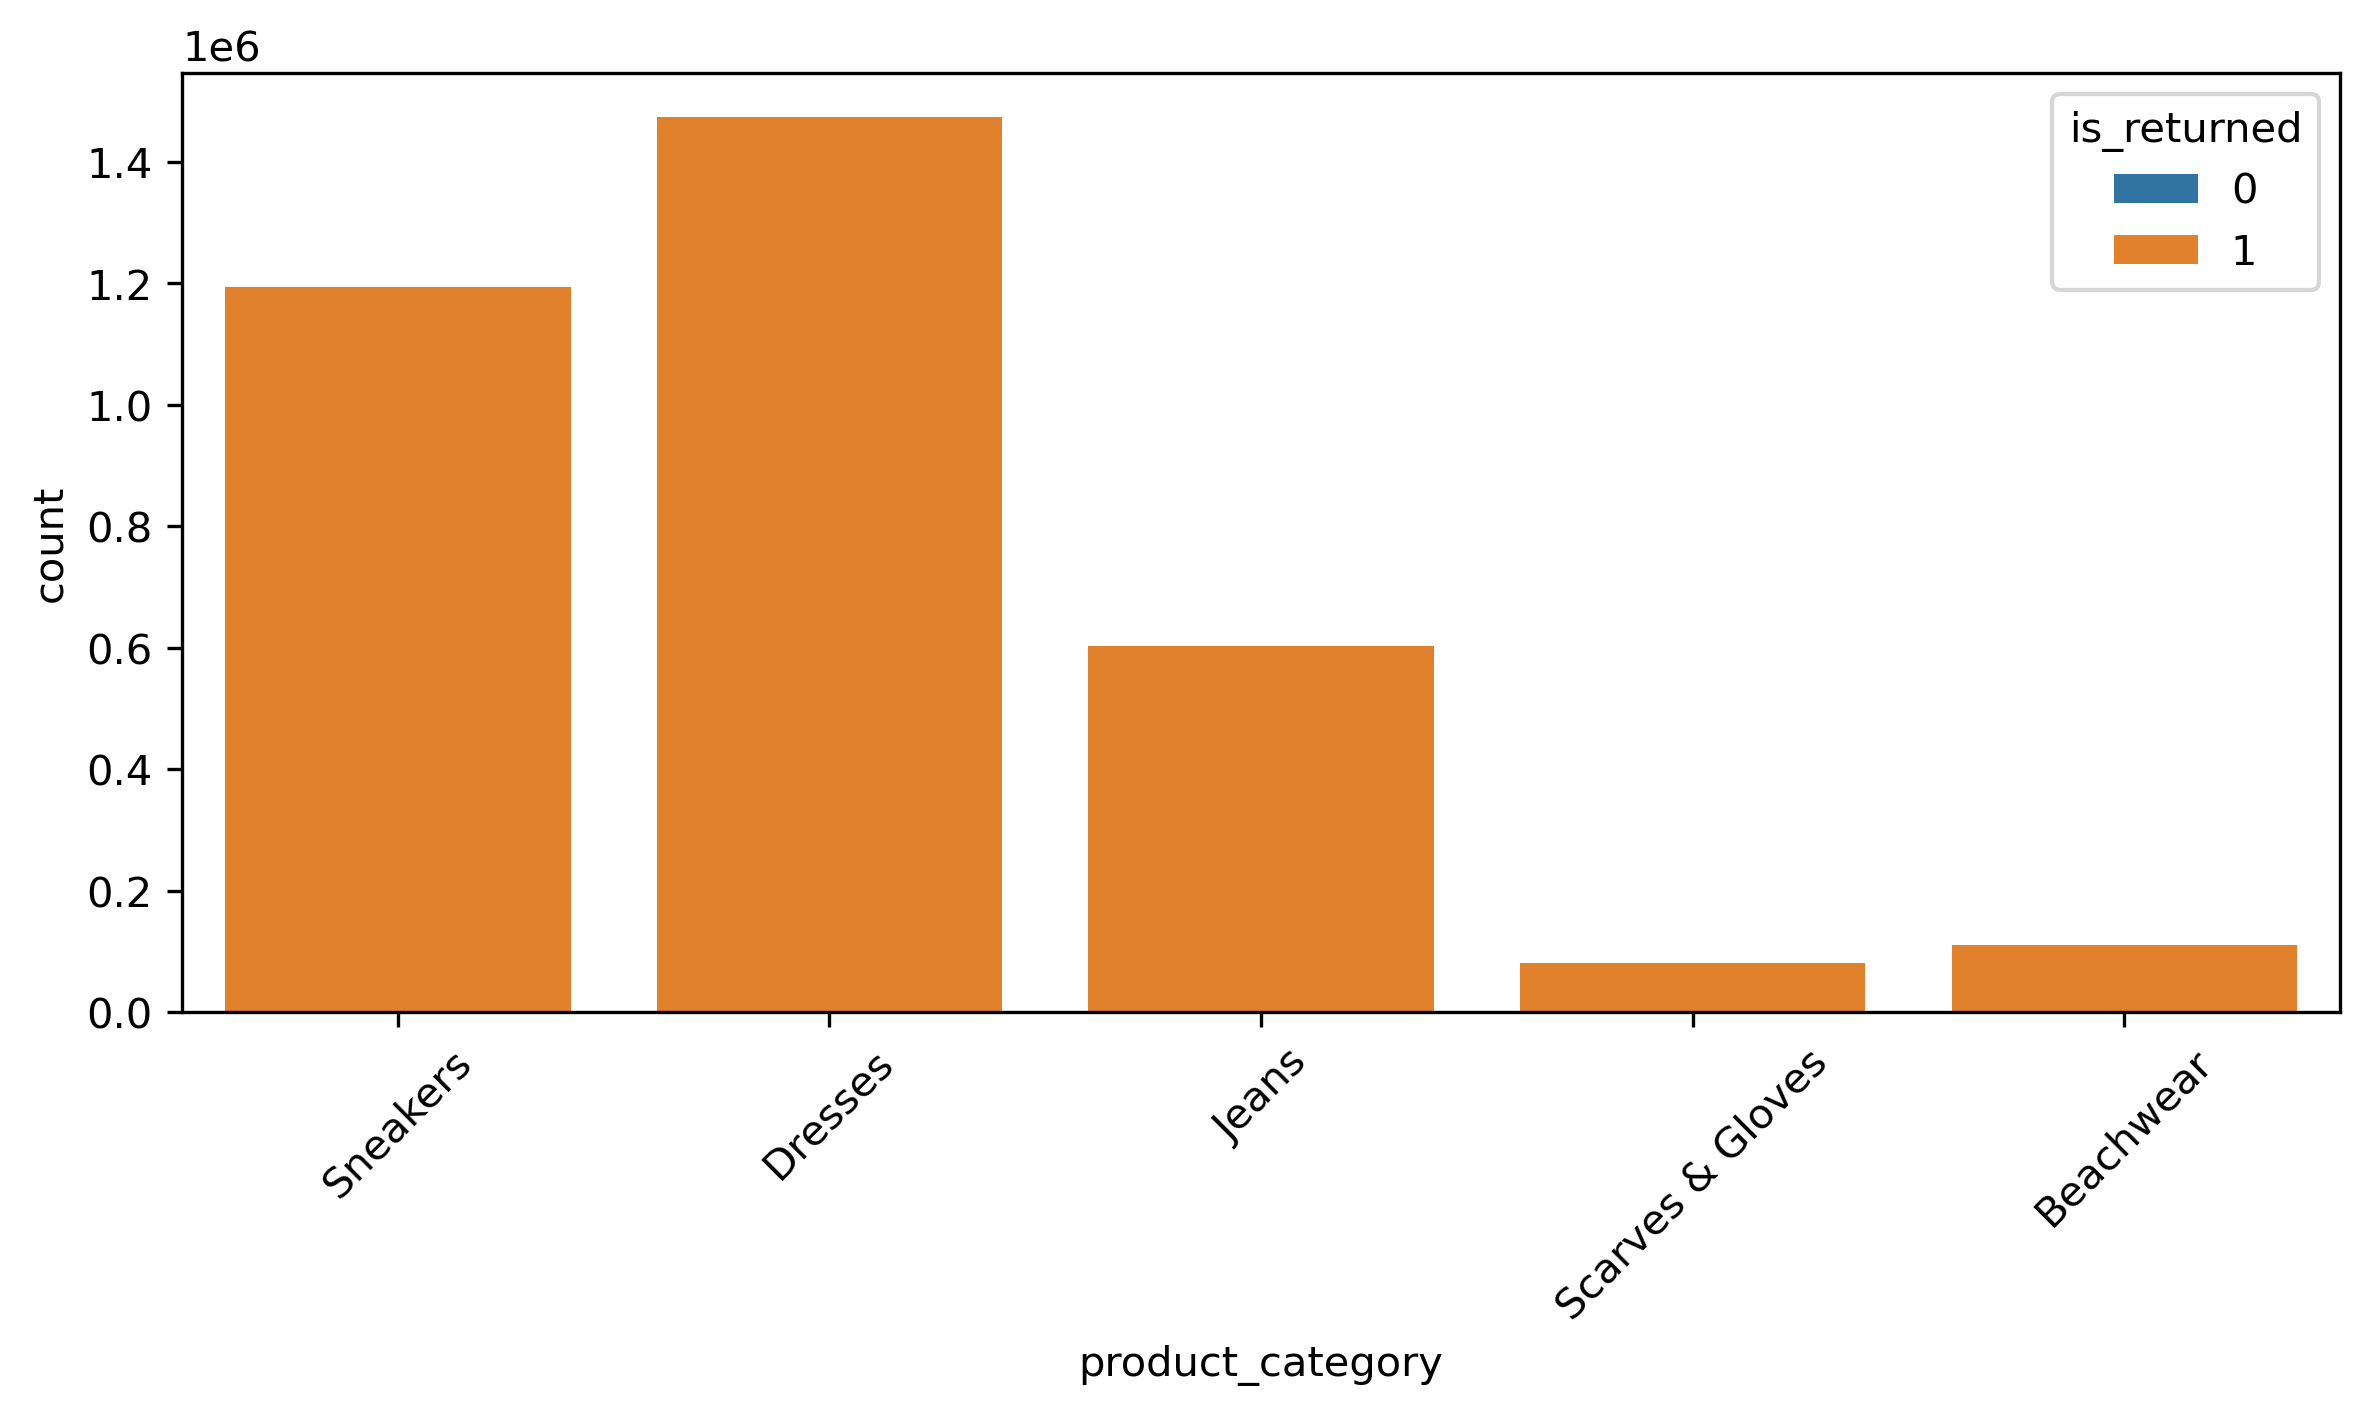

In [ ]:
plt.figure(figsize=(8,4),dpi=300)
sns.countplot(data=df, x='product_category')
plt.tight_layout()
plt.xticks(rotation=45)